# Simple Music OMR

## Imports

In [1]:
! pip install -q keras-tuner > /dev/null
! pip install -q editdistance > /dev/null
! pip install -q ordered_set > /dev/null

print("Packages installed")

Packages installed


In [2]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import random
import json
import editdistance
import pickle

from cv2 import imread, resize, IMREAD_GRAYSCALE
from ordered_set import OrderedSet

from google.colab.patches import cv2_imshow
from google.colab import drive

import tensorflow as tf
import keras.backend as K
import keras_tuner as kt

from keras.utils import pad_sequences, plot_model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPool2D, Dropout, Bidirectional, LSTM, Dense, Lambda, Reshape
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, BackupAndRestore, LearningRateScheduler
from keras.applications import VGG19

from tensorflow import data as tf_data

print(f'Tensorflow version {tf.__version__}, Available GPUs: {len(tf.config.list_physical_devices("GPU"))}')

Using TensorFlow backend
Tensorflow version 2.14.0, Available GPUs: 0


## Environment intialization

Mount drive folder

In [3]:
drive.mount('/content/drive')
DRIVE_DIR = '/content/drive/MyDrive/Cristofani'

Mounted at /content/drive


Paths and directories

In [4]:
DATASET_PATHS = ['/content/data/primus/package_aa', '/content/data/primus/package_ab']
DATA_DIR = os.path.join(DRIVE_DIR, 'data')
MODELS_DIR = os.path.join(DRIVE_DIR, 'models')
BACKUP_DATASET = os.path.join(DATA_DIR, 'primus.tar')
PREPARED_DATA = os.path.join(DATA_DIR, 'prepared_data.pkl')

if not os.path.exists(DATA_DIR):
  os.makedirs(DATA_DIR)

if not os.path.exists(MODELS_DIR):
  os.makedirs(MODELS_DIR)

Configuration values

In [5]:
# Training data
FORMAT = 'semantic'
SHUFFLE_SEED = 10

# Data splitting
VAL_SPLIT = 0.10
TEST_SPLIT = 0.20

# Data processing
CUSTOM_HEIGTH = 32
CUSTOM_WIDTH = 256
CUSTOM_CHANNELS = 1

PRETRAINED_HEIGTH = 32
PRETRAINED_WIDTH = 1024
PRETRAINED_CHANNELS = 3

# Training model
INPUT_SEQUENCE_LEN = 128
TARGET_SCORE = 0

# Training parameters
CUSTOM_LEARNING_RATE = 5e-04
PRETRAINED_LEARNING_RATE = 1e-03
CUSTOM_BATCH_SIZE = 64
PRETRAINED_BATCH_SIZE = 32
EPOCHS = 10
MAX_TUNER_EPOCHS = 5
PATIENCE = 3

# Default model hyperparameters
CUSTOM_INPUT_SHAPE = (CUSTOM_HEIGTH, CUSTOM_WIDTH, CUSTOM_CHANNELS)
PRETRAINED_INPUT_SHAPE = (PRETRAINED_HEIGTH, PRETRAINED_WIDTH, PRETRAINED_CHANNELS)

KERNEL_SIZE = 3
CNN_DROPOUT = 0.30
CNN_ACTIVATION = ReLU
RNN_UNITS = 256
RNN_DROPOUT = 0.45

Define encoding/decoding functions

In [6]:
encoder = {}
decoder = {}

def build_encoder_decoder(symbols):

  global encoder
  global decoder

  encoder = {}
  decoder = {}

  # Suffle codes
  codes = list(range(0, len(symbols)))
  random.Random(SHUFFLE_SEED).shuffle(codes)

  # Assign random code to each symbols
  for code, symbol in zip(codes, symbols):
    encoder[symbol] = code

  # Swap key-value to decode an encoded symbol
  decoder = {value: key for key, value in encoder.items()}

def encode_from_semantic(incipit):
    encoded_incipit = []
    for symbol in incipit:
      try:
        if symbol in encoder:
          encoded_incipit.append(encoder[symbol])
        else:
          encoded_incipit.append(0)
      except:
          print(f'Unknown symbol: {symbol}')

    return encoded_incipit

def decode_to_semantic(incipit):
  decoded_incipit = []
  for code in incipit:
    if code == -1 or code == len(decoder):
      continue
    try:
      decoded_incipit.append(decoder[code])
    except:
      print(f'Unknown code: {code}')

  return decoded_incipit

## Data preparation

The [PrIMuS](https://grfia.dlsi.ua.es/primus/) (*Printed Images of Music Staves*) dataset is composed by more than 80.000 incipits, i.e. the firts bars of a musical work.

Each incipit is represented in multiple formats, those of interest are:
* Graphical representation, synthetic musical staff image
* Semantic representation, contextualized list of graphical symbols


Download

In [7]:
if os.path.exists("data/primus"):
  print("Data already loaded")
elif not os.path.exists(BACKUP_DATASET):
  ! mkdir -p data/primus
  ! wget https://grfia.dlsi.ua.es/primus/packages/primusCalvoRizoAppliedSciences2018.tgz
  ! cp  /content/primusCalvoRizoAppliedSciences2018.tgz /content/drive/MyDrive/Cristofani/data
  ! tar xf /content/primusCalvoRizoAppliedSciences2018.tgz -C data/primus
  ! tar -cf {BACKUP_DATASET} --files-from <(find data/primus -type f \( -name "*.png" -o -name "*.semantic" \) -not -name ".*")
  print("Data loaded from dataset source")
else:
  ! mkdir -p data/primus
  ! cp {BACKUP_DATASET} .
  ! tar xf primus.tar
  print("Data loaded from drive folder")

Data loaded from drive folder


Load prepared data

In [8]:
preloaded = False
if os.path.exists(PREPARED_DATA):
  with open(PREPARED_DATA, 'rb') as fp:
    prepared_data = pickle.load(fp)

    dataset = prepared_data['dataset']
    encoder = prepared_data['encoder']
    decoder = prepared_data['decoder']
    available_symbols = prepared_data['available_symbols']
    max_length = prepared_data['max_incipit_len']

    preloaded = True

    print("Dataset loaded from the drive folder")
else:
  print("No prepared data available in the drive folder")

Dataset loaded from the drive folder


### Retrieve and prepare data

Retrieve available data

In [ ]:
available_symbols = OrderedSet([])
incipits = {
    'path':[],
    'image': [],
    'symbols': [],
    'length': []
}
max_length = 0

for path in DATASET_PATHS:
  incipits['path'].extend(glob.glob(os.path.join(path, '*')))

# Data are sorted and then shuffled (sorting guarantee the same initial order)
incipits['path'].sort()
random.Random(SHUFFLE_SEED).shuffle(incipits['path'])

print(f'Available incipits (samples): {len(incipits["path"])}')
# Read all semantic files (TSV of symbols)
for path in incipits['path']:
  incipits['image'].append(os.path.join(path, f'{os.path.basename(path)}.png'))

  with open(os.path.join(path, f'{os.path.basename(path)}.{FORMAT}'), 'r') as fin:
    symbols = fin.read().split('\t')[:-1]

    # Define vocabulary
    incipits['symbols'].append(symbols)

    # Save incipit lenght (# symbols)
    incipits['length'].append(len(symbols))

    # Save symbols
    for symbol in symbols:
      available_symbols.add(symbol)

    # Save maximum incipit length
    max_length = max(max_length, len(symbols))

print(f'Number of symbols: {len(available_symbols)}')
print(f'Max incipit length: {max_length}')

Available incipits (samples): 87678
Number of symbols: 1781
Max incipit length: 58


Build encoder/decoder

In [ ]:
build_encoder_decoder(available_symbols)

Encode and pad all incipits

In [ ]:
incipits['encoded'] = pad_sequences(
  list(map(encode_from_semantic, incipits['symbols'])),
  maxlen=max_length,
  padding='post',
  value = len(encoder)).tolist()

Example encoded incipit

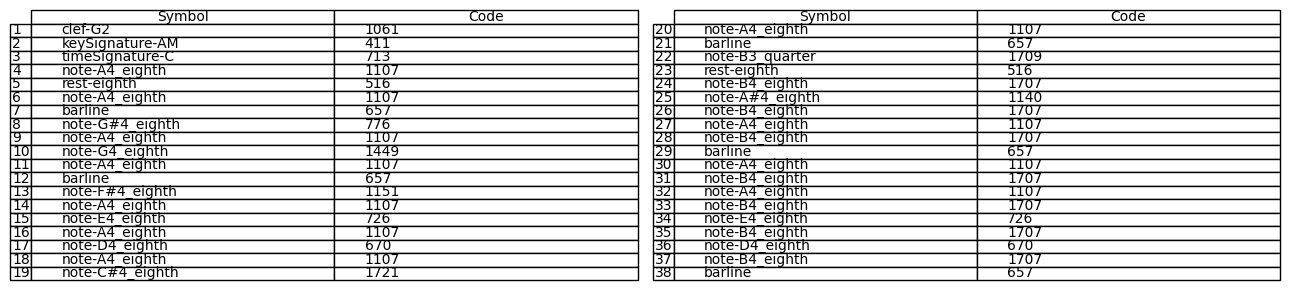

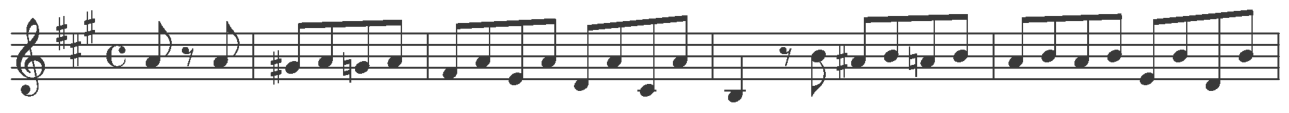

In [ ]:
for index in range(0, 1):

  # Show list of symbols
  fig, ax = plt.subplots(1, 2, figsize=(13,3))
  mid = len(incipits['symbols'][index]) // 2
  ax[0].table(
      cellText=list(zip(incipits['symbols'][index], incipits['encoded'][index]))[:mid],
      rowLabels=list(range(1, mid + 1)),
      bbox=[0, 0, 1, 1],
      colLabels=('Symbol','Code'),
      cellLoc='left')
  ax[0].axis('off')
  ax[1].table(
    cellText=list(zip(incipits['symbols'][index], incipits['encoded'][index]))[mid:],
    rowLabels=list(range(mid + 1, len(incipits['symbols'][index]) + 1)),
    bbox=[0, 0, 1, 1],
    colLabels=('Symbol','Code'),
    cellLoc='left')
  ax[1].axis('off')

  fig.tight_layout()
  fig.show()

  # Show incipit
  fig, ax = plt.subplots(1,1, figsize=(13,3))
  ax.imshow(imread(incipits['image'][index]))
  ax.axis('off')
  fig.tight_layout()
  fig.show()

Build prepared data and save them into drive folder in order to be restored in future

In [ ]:
n_incipits = len(incipits['path'])

test_size = round(TEST_SPLIT * n_incipits)
val_size = round(VAL_SPLIT * n_incipits)
train_size = n_incipits - val_size - test_size

dataset = {
  'train': {
      'image': incipits['image'][:train_size],
      'encoded': incipits['encoded'][:train_size],
      'length': incipits['length'][:train_size]
  },
  'val': {
      'image': incipits['image'][train_size:train_size + val_size],
      'encoded': incipits['encoded'][train_size:train_size + val_size],
      'length': incipits['length'][train_size:train_size + val_size]
  },
  'test': {
      'image': incipits['image'][-test_size:],
      'encoded': incipits['encoded'][-test_size:],
  }
}

# Save into binary format to save space
with open(PREPARED_DATA, 'wb') as fp:
  prepared_data = {
    'dataset': dataset,
    'encoder': encoder,
    'decoder': decoder,
    'available_symbols': available_symbols,
    'max_incipit_len': max_length
  }
  pickle.dump(prepared_data, fp)

  print("Dataset dumped to drive folder")

Dataset dumped to drive folder


### Data analysis

In [9]:
if preloaded:
  images = dataset['train']['image'] + dataset['val']['image'] + dataset['test']['image']
  symbols = list(map(decode_to_semantic, dataset['train']['encoded'])) + list(map(decode_to_semantic, dataset['val']['encoded'])) + list(map(decode_to_semantic, dataset['test']['encoded']))
else:
  images = incipits['image']
  symbols = incipits['symbols']

#### Symbols occurrences (how many times they appear in the dataset)

In [10]:
symbol_occurrences = {symbol: 0 for symbol in available_symbols}
for incipit in symbols:
  for symbol in incipit:
    symbol_occurrences[symbol] += 1

* Median          : 15
* Mean            : 1177
* 1 percentile    : 1
* 99 percentile   : 22734
* Max             : 326984


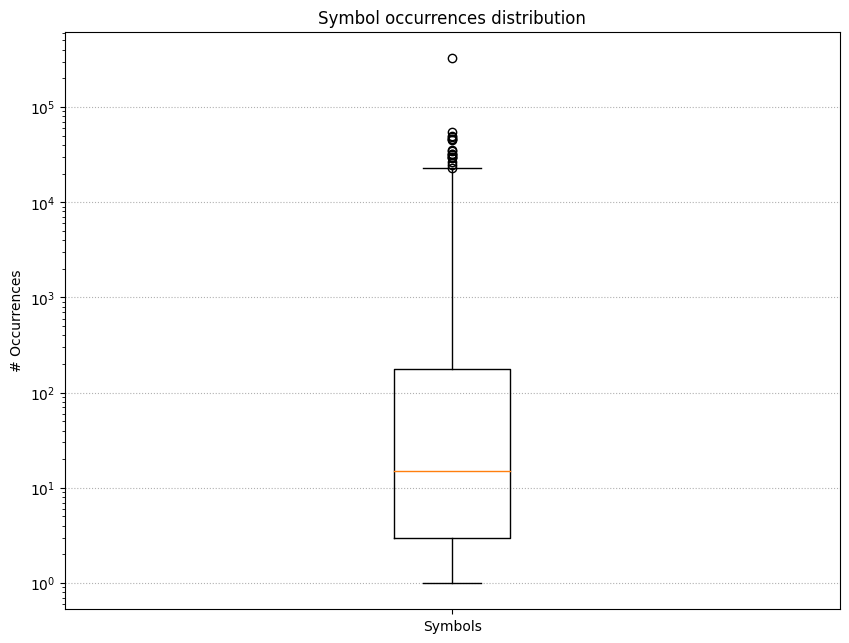

In [11]:
occurrences = list(symbol_occurrences.values())
fig, ax = plt.subplots(1,1, figsize=(10,7.5))

stats = cbook.boxplot_stats(occurrences, labels='S')[0]
stats['whislo'], stats['whishi'] = np.percentile(occurrences, [1, 99])
stats['fliers'] = list(filter(lambda v: v > stats['whishi'], occurrences))
stats['label'] = 'Symbols'

ax.bxp([stats])
ax.set_yscale('log')
ax.set_ylabel('# Occurrences')
ax.grid(axis='y', linestyle='dotted')
ax.set_title('Symbol occurrences distribution')

print(f'* {"Median":15} : {int(stats["med"])}')
print(f'* {"Mean":15} : {round(stats["mean"])}')
print(f'* {"1 percentile":15} : {round(stats["whislo"])}')
print(f'* {"99 percentile":15} : {round(stats["whishi"])}')
print(f'* {"Max":15} : {round(max(occurrences))}')

fig.show()

#### Incipit length

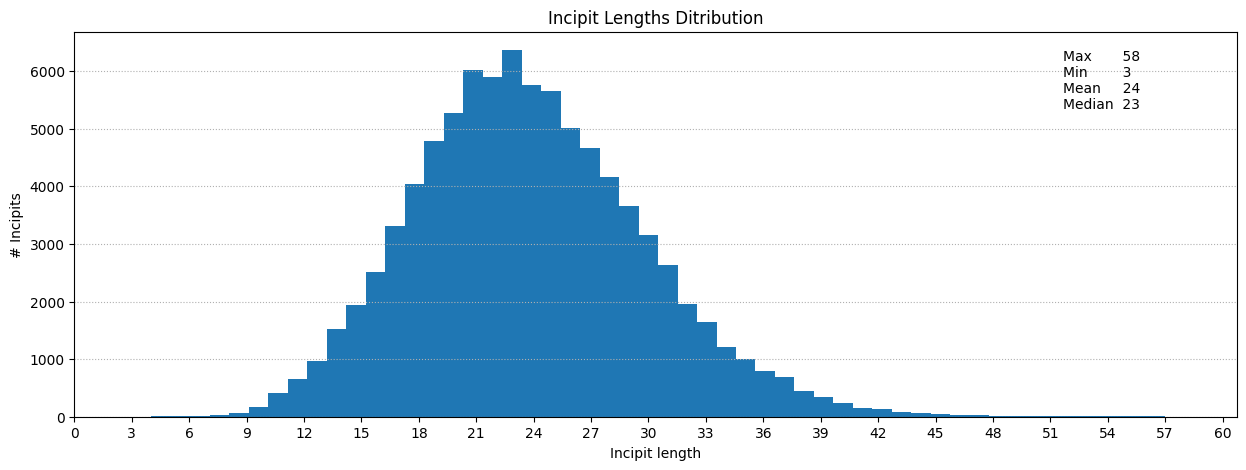

In [12]:
lengths = [len(incipit) for incipit in symbols]

max_length = round(np.amax(lengths))
min_length = round(np.amin(lengths))
mean_length = round(np.mean(lengths))
median_length = round(np.median(lengths))

fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.hist(lengths, bins=54)
ax.text(
     0.85 * (ax.get_xlim()[1] - ax.get_xlim()[0]) + ax.get_xlim()[0],
     0.8 * (ax.get_ylim()[1] - ax.get_ylim()[0]) + ax.get_ylim()[0],
     f'{"Max":9} {max_length} \n{"Min":10} {min_length} \n{"Mean":8} {mean_length} \n{"Median":7} {median_length}',
     transform=ax.transData)

ax.grid(axis='y', linestyle='dotted')
ax.set_title('Incipit Lengths Ditribution')
ax.set_xlabel('Incipit length')
ax.set_ylabel('# Incipits')
ax.set_xticks(np.linspace(0, 60, 21))
fig.show()

#### Assees symbol distribution in sets

In [13]:
training_symbols = set([])
for symbols in dataset['train']['encoded']:
  for symbol in symbols:
    if symbol == -1 or symbol == len(encoder):
      continue
    else:
      training_symbols.add(symbol)

print(f'Available symbols: {len(available_symbols)}, Training symbols: {len(training_symbols)}')

Available symbols: 1781, Training symbols: 1679


In [14]:
def qq_plot(occurencies_ds):

  fig, axes = plt.subplots(1, 3, figsize=(20, 5))
  quantiles = []
  sets = ['Training', 'Validation', 'Test']
  indexes = [(0,1), (0,2), (2,1)]
  for index, occurrences in enumerate(occurencies_ds):
    quantiles.append([np.percentile(occurrences, p) for p in np.linspace(0, 100, num=101)])

  for ax, (x, y) in zip(axes, indexes):
    ax.plot(np.linspace(0, len(available_symbols)), np.linspace(0, len(available_symbols)), linestyle='dotted', color='grey')
    ax.scatter(quantiles[x], quantiles[y], s=50, marker='.')

    ax.set_title(f'{sets[x]}-{sets[y]}')

    ax.set_xlabel(f'{sets[x]} quantiles')
    ax.set_ylabel(f'{sets[y]} quantiles')
    ax.grid()

  fig.suptitle('Symbol distribution QQ-Plots')
  fig.tight_layout()
  fig.show()

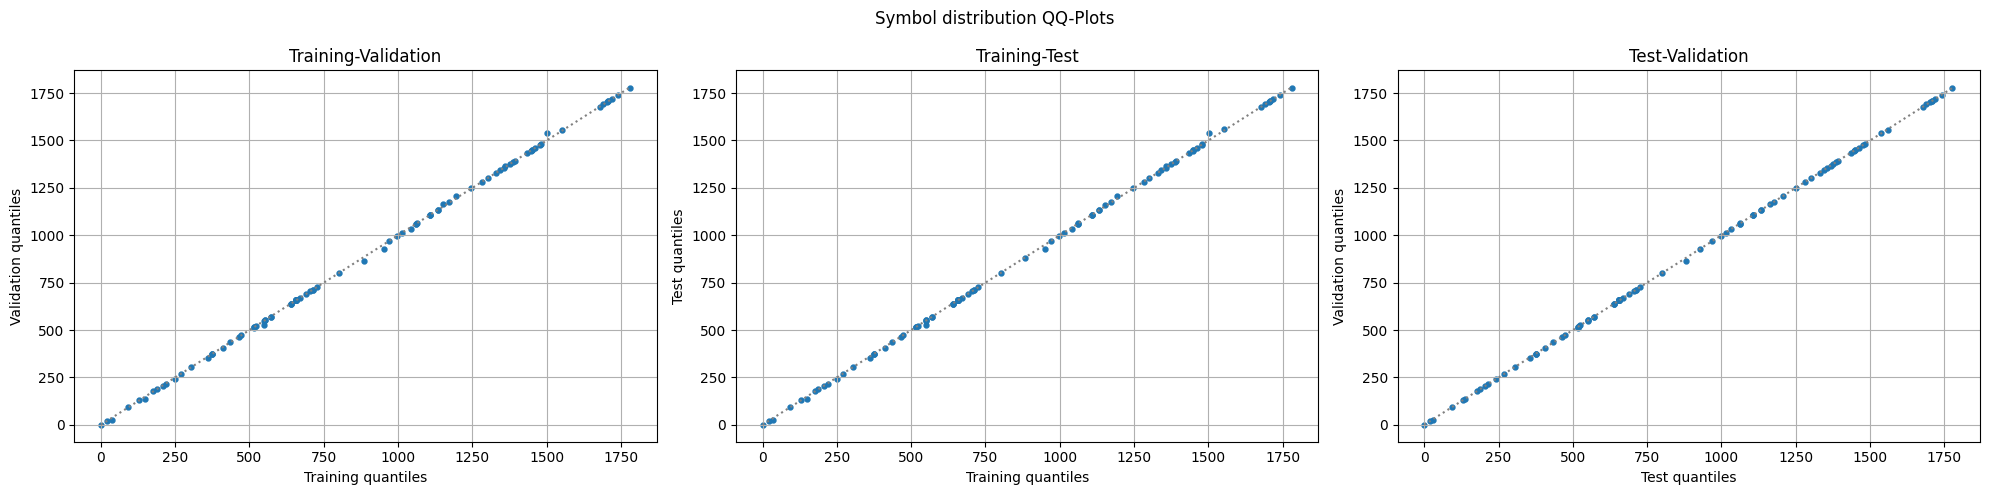

In [15]:
occurencies_ds = []
for key in dataset:
  occurencies = []
  for incipit in dataset[key]['encoded']:
    for symbol in incipit:
      if symbol == -1 or symbol == len(encoder):
        continue
      occurencies.append(symbol)

  occurencies_ds.append(occurencies)

qq_plot(occurencies_ds)

### Build tensorflow datasets

In [ ]:
def preprocessing(incipit):
  image = tf.io.read_file(incipit['image'])
  image = tf.image.decode_png(image, channels=CUSTOM_CHANNELS)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.image.resize(image, (CUSTOM_HEIGTH, CUSTOM_WIDTH))

  return (image, incipit['encoded'], INPUT_SEQUENCE_LEN, incipit['length']), TARGET_SCORE

def test_preprocessing(incipit):
  image = tf.io.read_file(incipit['image'])
  image = tf.image.decode_png(image, channels=CUSTOM_CHANNELS)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.image.resize(image, (CUSTOM_HEIGTH, CUSTOM_WIDTH))

  return image, incipit['encoded']

Train set      : 61374
Val set        :  8768
Test set       : 17536


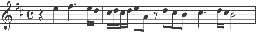

In [ ]:
custom_train_ds = tf.data.Dataset                                       \
  .from_tensor_slices(dataset['train'])                                 \
  .map(preprocessing, num_parallel_calls=tf_data.AUTOTUNE)              \
  .cache()                                                              \
  .shuffle(buffer_size=1000, reshuffle_each_iteration=True)             \
  .batch(CUSTOM_BATCH_SIZE)                                             \
  .prefetch(tf_data.AUTOTUNE)

custom_val_ds = tf.data.Dataset                                         \
  .from_tensor_slices(dataset['val'])                                   \
  .map(preprocessing, num_parallel_calls=tf_data.AUTOTUNE)              \
  .batch(CUSTOM_BATCH_SIZE)                                             \
  .cache()

custom_test_ds = tf.data.Dataset                                        \
  .from_tensor_slices(dataset['test'])                                  \
  .map(test_preprocessing, num_parallel_calls=tf_data.AUTOTUNE)         \
  .batch(CUSTOM_BATCH_SIZE)

train_size = len(dataset['train']['image'])
val_size = len(dataset['val']['image'])
test_size = len(dataset['test']['image'])

print(f'{"Train set":15}: {train_size:5}')
print(f'{"Val set":15}: {val_size:5}')
print(f'{"Test set":15}: {test_size:5}')

cv2_imshow(next(iter((custom_train_ds.take(1))))[0][0][0].numpy() * 255)

In [ ]:
def preprocessing(incipit):
  image = tf.io.read_file(incipit['image'])
  image = tf.image.decode_png(image, channels=PRETRAINED_CHANNELS)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.image.resize(image, (PRETRAINED_HEIGTH, PRETRAINED_WIDTH))

  return (image, incipit['encoded'], INPUT_SEQUENCE_LEN, incipit['length']), TARGET_SCORE

def test_preprocessing(incipit):
  image = tf.io.read_file(incipit['image'])
  image = tf.image.decode_png(image, channels=PRETRAINED_CHANNELS)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.image.resize(image, (PRETRAINED_HEIGTH, PRETRAINED_WIDTH))

  return image, incipit['encoded']

Train set      : 61374
Val set        :  8768
Test set       : 17536


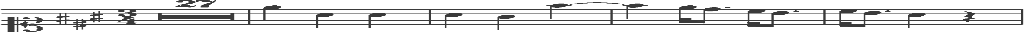

In [ ]:
pretrained_train_ds = tf.data.Dataset.from_tensor_slices(dataset['train'])  \
  .map(preprocessing, num_parallel_calls=tf_data.AUTOTUNE)                  \
  .shuffle(buffer_size=1000, reshuffle_each_iteration=True)                 \
  .batch(PRETRAINED_BATCH_SIZE)                                             \
  .prefetch(tf_data.AUTOTUNE)

pretrained_val_ds = tf.data.Dataset.from_tensor_slices(dataset['val'])      \
  .map(preprocessing, num_parallel_calls=tf_data.AUTOTUNE)                  \
  .batch(PRETRAINED_BATCH_SIZE)

pretrained_test_ds = tf.data.Dataset                                        \
  .from_tensor_slices(dataset['test'])                                      \
  .map(test_preprocessing, num_parallel_calls=tf_data.AUTOTUNE)             \
  .batch(PRETRAINED_BATCH_SIZE)

train_size = len(dataset['train']['image'])
val_size = len(dataset['val']['image'])
test_size = len(dataset['test']['image'])

print(f'{"Train set":15}: {train_size:5}')
print(f'{"Val set":15}: {val_size:5}')
print(f'{"Test set":15}: {test_size:5}')

cv2_imshow(next(iter((pretrained_train_ds.take(1))))[0][0][0].numpy() * 255)

## Models

### Utility functions

Training loss functions

In [ ]:
def ctc_loss(args):
  predicted_sequence_batch, target_sequence_batch, input_sequence_len_batch, target_sequence_len_batch = args
  return K.ctc_batch_cost(
      target_sequence_batch,
      predicted_sequence_batch,
      input_sequence_len_batch,
      target_sequence_len_batch
  )

def null_loss(x, y):
  return y

Decode models output

In [ ]:
def decode_output(ctc_predictions):
   return K.ctc_decode(ctc_predictions, input_length=np.ones(ctc_predictions.shape[0]) * ctc_predictions.shape[1], greedy=True)[0][0]

Learning rate scheduler

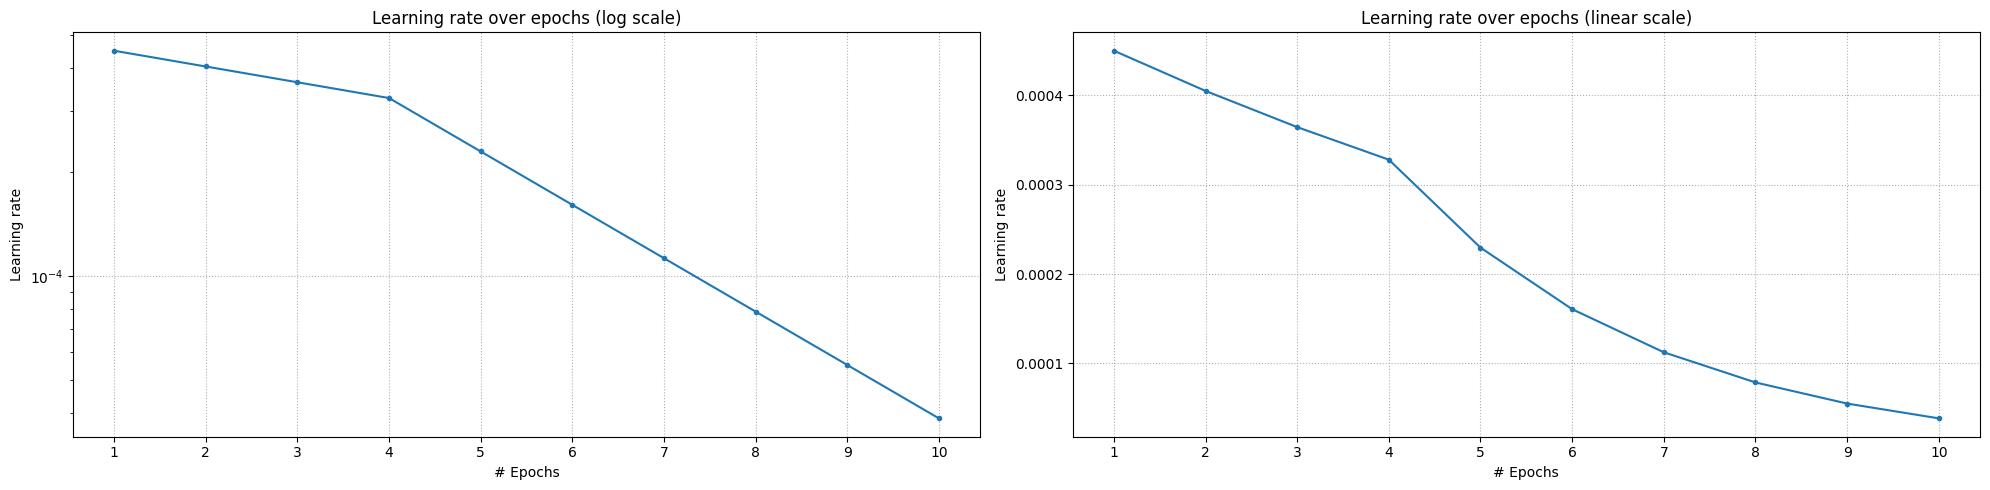

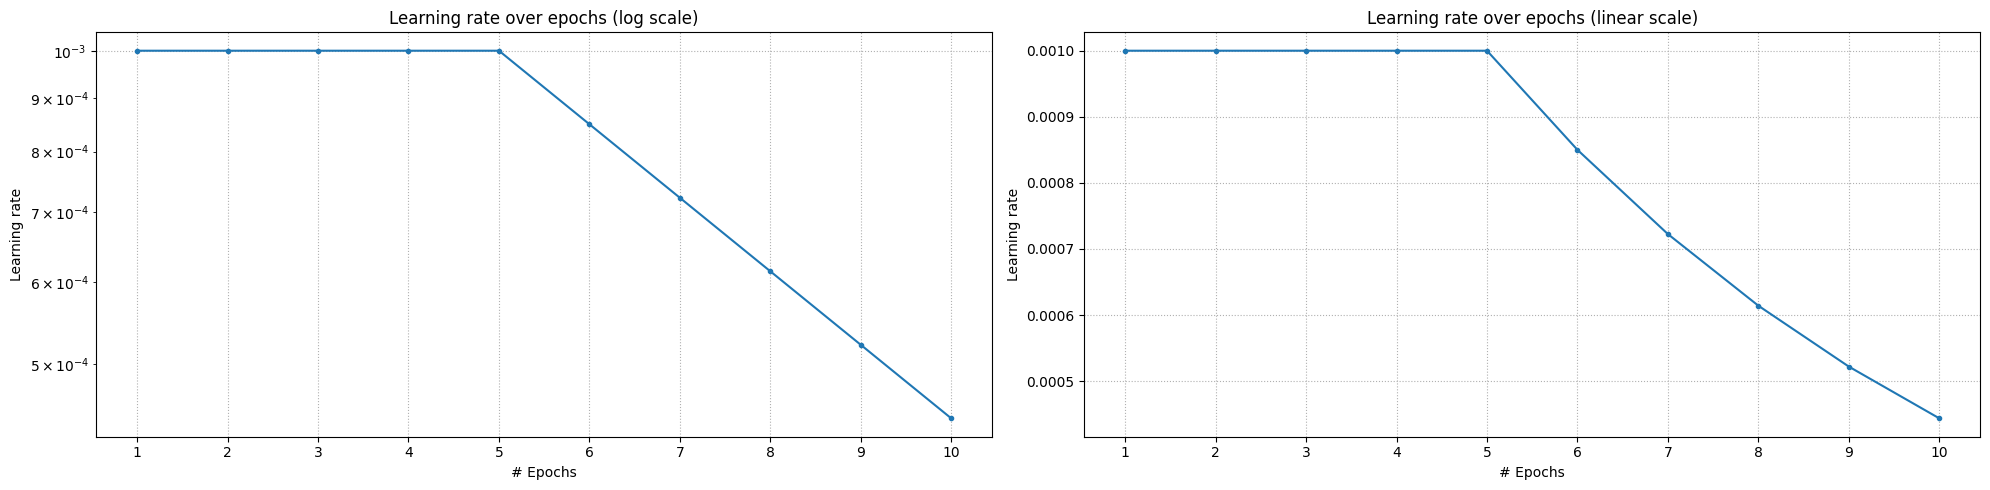

In [ ]:
def custom_lr_scheduler(epoch, lr):
  if epoch >= 4:
    return lr * 0.70
  else:
    return lr * 0.90

def pretrained_lr_scheduler(epoch, lr):
  if epoch >= 5:
    return lr * 0.85
  else:
    return lr

for sched, lr in zip([custom_lr_scheduler, pretrained_lr_scheduler],[CUSTOM_LEARNING_RATE, PRETRAINED_LEARNING_RATE]):
  fig, axes = plt.subplots(1,2, figsize=(20, 5))
  rates = [lr]
  for epoch in range(0, 10):
    rates.append(sched(epoch, rates[-1]))

  axes[0].set_yscale('log')
  axes[0].set_title('Learning rate over epochs (log scale)')
  axes[1].set_title("Learning rate over epochs (linear scale)")

  for ax in axes:
    ax.plot(range(1, 11), rates[1:], marker='.')
    ax.set_xlabel('# Epochs')
    ax.set_ylabel('Learning rate')
    ax.grid(linestyle='dotted')
    ax.set_xticks(np.linspace(1, 10, 10))

  fig.tight_layout()
  fig.show()

### Evaluation metrics

Symbol error rate

In [ ]:
def ser(gt, pred):
    error_rate = abs(len(gt) - len(pred))
    for gt_symbol, pred_symbol in zip(gt, pred):
      error_rate += 0 if gt_symbol == pred_symbol else 1

    return error_rate / len(gt)

def batch_symbol_error_rate(gt_batch, pred_batch):
  total_error_rate = 0
  for gt, pred in zip(gt_batch, pred_batch):

    # Decode symbols
    gt = decode_to_semantic(gt)
    pred = decode_to_semantic(pred)

    # Sum error rate
    total_error_rate += ser(gt, pred)

  return total_error_rate / len(gt_batch)


def symbol_error_rate(ground_truth, prediction):
  return tf.py_function(lambda gt, pred: batch_symbol_error_rate(gt.numpy(), decode_output(pred).numpy()), inp=[ground_truth, prediction], Tout=tf.float32)

Edit distance (Levenshtein distance)

In [ ]:
def batch_norm_edit_distance(gt_batch, pred_batch):
  distance = 0
  for gt, pred in zip(gt_batch, pred_batch):
    gt = decode_to_semantic(gt)
    pred = decode_to_semantic(pred)
    distance += editdistance.eval(gt, pred) / len(gt)

  return distance / len(gt_batch)


def norm_edit_distance(ground_truth, prediction):
  return tf.py_function(lambda gt, pred: batch_norm_edit_distance(gt.numpy(), decode_output(pred).numpy()), inp=[ground_truth, prediction], Tout=tf.float32)

### Class methods

In [ ]:
def tune_hyperparams(self, max_tuner_epochs, train_ds, val_ds, batch_size):

  # Instantiate tuner
  tuner = kt.Hyperband(
      hypermodel=lambda hp: self.hyper_builder(hp),
      objective='val_loss',
      overwrite=True,
      max_epochs=max_tuner_epochs,
      directory=self.dirs['hyperband'],
      project_name=self.model_name)

  # Hyperband searching
  tuner.search(
      train_ds,
      batch_size=batch_size,
      validation_data=val_ds,
      callbacks=[EarlyStopping(
          monitor='val_loss',
          patience=PATIENCE,
          restore_best_weights=True)
      ])

  best_hps = tuner.get_best_hyperparameters()[0]

  # Save results
  with open(self.paths['tuner'], 'w') as fp:
    json.dump(best_hps.values, fp, indent=2)

  return best_hps

In [ ]:
def train_model(self, train_ds, val_ds, epochs, batch_size):

  # Train model
  history = self.training_model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=self.callbacks)

  # Save histories
  if len(history.history) > 0:
    self.histories.append(history.history)
    if 'lr' in history.history:
      del history.history['lr']
    with open(self.paths['history'], 'w') as fp:
      json.dump(self.histories, fp)

  return history

In [ ]:
def plot_training_trend(self):

  # Merge epochs
  train_loss = []
  val_loss = []
  for h in self.histories:
    train_loss.extend(h['loss'])
    val_loss.extend(h['val_loss'])

  # Show loss trend
  fig, ax = plt.subplots(1, 1, figsize=(15, 5))
  ax.plot(train_loss, label='Training Loss')
  ax.plot(val_loss, label='Validation Loss')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.set_title('Training and Validation Loss Over Time')
  ax.legend()
  ax.grid()

  fig.suptitle(self.model_name)
  fig.tight_layout()
  fig.show()

In [ ]:
def evaluate_model(self, test_ds):

  # Load the saved best model weights
  if os.path.exists(self.paths['model']):
    self.model.load_weights(self.paths['model'])
  else:
    print("Weigths not available")

  # Evaluate new score
  score = self.model.evaluate(test_ds)

  # Save scores
  self.scores.append(score)
  with open(self.paths['score'], 'w') as fp:
    json.dump(self.scores, fp)

  return score

In [ ]:
def predict(self, data, batch_size):

  # Load the saved best model weights
  if os.path.exists(self.paths['model']):
    self.model.load_weights(self.paths['model'])
  else:
    print("Weigths not available")

  ctc_predictions = self.model.predict(data, batch_size, verbose=0)
  predictions = K.ctc_decode(ctc_predictions, input_length=np.ones(ctc_predictions.shape[0]) * ctc_predictions.shape[1], greedy=True)[0][0]

  return predictions

### Layers

In [ ]:
def OMRConvNet512(input_shape, kernel_size, droput, activation_layer):
  conv_net = Sequential([
    Input(input_shape, name='input'),

    Conv2D(32, kernel_size, padding='same', name='conv32'),
    BatchNormalization(name='batch_norm_1'),
    activation_layer(name='activation_1'),
    MaxPool2D(pool_size=(2, 2), name='max_pool_2x2'),
    Dropout(droput, name='dropout_1'),

    Conv2D(64, kernel_size, padding='same', name='conv64'),
    BatchNormalization(name='batch_norm_2'),
    activation_layer(name='activation_2'),
    MaxPool2D(pool_size=(2, 1), name='max_pool_2x1_1'),
    Dropout(droput, name='dropout_2'),

    Conv2D(128, kernel_size, padding='same', name='conv128'),
    BatchNormalization(name='batch_norm_3'),
    activation_layer(name='activation_3'),
    MaxPool2D(pool_size=(2, 1), name='max_pool_2x1_2'),
    Dropout(droput, name='dropout_3'),

    Conv2D(256, kernel_size, padding='same', name='conv256'),
    BatchNormalization(name='batch_norm_4'),
    activation_layer(name='activation_4'),
    MaxPool2D(pool_size=(2, 1), name='max_pool_2x1_3'),
    Dropout(droput, name='dropout_4'),

    Conv2D(512, kernel_size, padding='same', name='conv512'),
    BatchNormalization(name='batch_norm_5'),
    activation_layer(name='activation_5'),
    MaxPool2D(pool_size=(2, 1), name='max_pool_2x1_4'),
    Dropout(droput, name='dropout_5'),
  ])

  return conv_net

In [ ]:
def OMRBiRecNet2(rnn_input, rnn_units, rnn_dropout, n_symbols):

  # Bidirectional LSTM layers
  blstm_1 = Bidirectional(LSTM(rnn_units, return_sequences=True, dropout=rnn_dropout), name='bi_lstm_1')(rnn_input)
  blstm_2 = Bidirectional(LSTM(rnn_units, return_sequences=True, dropout=rnn_dropout), name='bi_lstm_2')(blstm_1)

  # Softmax output (numbers of symbols + empty symbol)
  output = Dense(n_symbols + 1, activation='softmax', name='output')(blstm_2)

  return output

In [ ]:
def CTCTrainingModel(model_input, model_output, max_sequence_len, lr):

  # Training model inputs (features from CNN, ground truth sequence, length of features from CNN and length of ground truth sequence)
  target_sequence = Input(name='target_sequence', shape=(max_sequence_len,), dtype='int64')
  input_sequence_len = Input(name='feature_length', shape=(1,), dtype='int64')
  target_sequence_len = Input(name='incipit_length', shape=(1,), dtype='int64')

  # Compute CTC loss
  loss_out = Lambda(ctc_loss, output_shape=(1,), name='ctc')([model_output, target_sequence, input_sequence_len, target_sequence_len])

  # Utility model to perform training via CTC function
  training_model = Model(inputs=[model_input, target_sequence, input_sequence_len, target_sequence_len], outputs=loss_out)

  # No function applied as loss function, the output of network function is itself the loss
  training_model.compile(
    loss=null_loss,
    optimizer=tf.optimizers.Adam(learning_rate=lr)
  )

  return training_model

### Classes

In [ ]:
class BaseModel():
  def __init__(self, model_name):
    self.model_name = model_name
    self.dirs = {
      'model': os.path.join(MODELS_DIR, model_name),
      'backup': os.path.join(MODELS_DIR, model_name, 'backup'),
      'hyperband': os.path.join(MODELS_DIR, model_name, 'hyperband'),
    }
    self.paths = {
      'layers': os.path.join(MODELS_DIR, model_name,f'{model_name}.json'),
      'model': os.path.join(MODELS_DIR, model_name, f'{model_name}.hdf5 '),
      'history': os.path.join(MODELS_DIR, model_name, 'history.json'),
      'score': os.path.join(MODELS_DIR, model_name, 'score.json'),
      'hyperparams': os.path.join(MODELS_DIR, model_name, 'hyperparams.json'),
      'tuner': os.path.join(MODELS_DIR, model_name, 'tuner.json')
    }
    self.hyperparams = {}
    self.conv_net = None
    self.model = None
    self.training_model = None

    # Training callbacks
    self.callbacks = [
        ModelCheckpoint(
            filepath=self.paths['model'],
            monitor='val_loss',
            save_best_only=True,
            mode='auto'),

        BackupAndRestore(
            backup_dir=self.dirs['backup'],
            save_freq="epoch",
            delete_checkpoint=False),

        EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True)
    ]

    # Create model directories
    for dir in self.dirs.values():
      if not os.path.exists(dir):
        os.makedirs(dir)

    # Load previous histories
    self.histories = []
    if os.path.exists(self.paths['history']):
      with open(self.paths['history'], 'r') as fp:
        self.histories = json.load(fp)
        print(f'Histories loaded: {len(self.histories)}')

    # Load previous scores
    self.scores = []
    if os.path.exists(self.paths['score']):
      with open(self.paths['score'], 'r') as fp:
        self.scores = json.load(fp)
        print(f'Scores loaded: {len(self.scores)}')

  def save_model_conf(self):
    with open(self.paths['hyperparams'], 'w') as fp:
      serialized_hp = {key: value if type(value) in [int, str, tuple, list, float] else value.__class__.__name__ for key, value in self.hyperparams.items()}
      json.dump(serialized_hp, fp, indent=2)

    with open(self.paths['layers'], 'w') as fp:
      json.dump(json.loads(self.model.to_json()), fp, indent=2)

# Add methods to BaseModel class
BaseModel.tune_hyperparams = tune_hyperparams
BaseModel.train = train_model
BaseModel.plot_training_trend = plot_training_trend
BaseModel.evaluate = evaluate_model
BaseModel.predict = predict


In [ ]:
class Custom512(BaseModel):
  def __init__(self, model_name, **kwargs):
    super().__init__(model_name)

    # Default hyperparameters
    self.hyperparams = {
      'input_shape': CUSTOM_INPUT_SHAPE,
      'kernel_size': KERNEL_SIZE,
      'cnn_dropout': CNN_DROPOUT,
      'cnn_activation': CNN_ACTIVATION,
      'rnn_units': RNN_UNITS,
      'rnn_dropout': RNN_DROPOUT,
      'learning_rate': CUSTOM_LEARNING_RATE,
      'n_symbols': len(encoder),
      'max_sequence_len': max_length
    }

    # Add learning rate scheduler callback
    self.callbacks.append(LearningRateScheduler(custom_lr_scheduler))

    # Override default hyperparameters
    for key, value in kwargs.items():
      self.hyperparams[key] = value

    # Build model
    self.conv_net, self.model, self.training_model = self.build(self.hyperparams)
    self.save_model_conf()

  def build(self, hyperparams):

    # Custom CNN for feature extraction
    conv_net = OMRConvNet512(
      hyperparams['input_shape'],
      hyperparams['kernel_size'],
      hyperparams['cnn_dropout'],
      hyperparams['cnn_activation']
    )

    # Reduce features size [(1, 128, 512) -> (128, 512)]
    rnn_input = Lambda(lambda x: K.squeeze(x, 1))(conv_net.output)

    # RNN network (stacked bidirectional LSTMs)
    output = OMRBiRecNet2(
      rnn_input,
      hyperparams['rnn_units'],
      hyperparams['rnn_dropout'],
      hyperparams['n_symbols']
    )

    # Inference model
    model = Model(conv_net.input, output)

    # Compile model with evaluation metrics
    model.compile(metrics=[norm_edit_distance, symbol_error_rate])

    # Training model
    training_model = CTCTrainingModel(
      conv_net.input,
      output,
      hyperparams['max_sequence_len'],
      hyperparams['learning_rate']
    )

    return conv_net, model, training_model


  def hyper_builder(self, hp):
    tuner_hyperparams = self.hyperparams

    # Override the hyperparams to tune
    tuner_hyperparams['cnn_dropout'] = hp.Choice('cnn_dropout', [0.15, 0.30, 0.45])
    tuner_hyperparams['rnn_dropout'] = hp.Choice('rnn_dropout', [0.15, 0.30, 0.45])

    return self.build(tuner_hyperparams)[-1]

In [ ]:
class PretrainedVGG19(BaseModel):
  def __init__(self, model_name, **kwargs):
    super().__init__(model_name)

    # Default hyperparameters
    self.hyperparams = {
      'input_shape': PRETRAINED_INPUT_SHAPE,
      'rnn_units': RNN_UNITS,
      'rnn_dropout': RNN_DROPOUT,
      'learning_rate': PRETRAINED_LEARNING_RATE,
      'n_symbols': len(encoder),
      'max_sequence_len': max_length
    }

    # Add learning rate scheduler
    self.callbacks.append(LearningRateScheduler(pretrained_lr_scheduler))

    # Override default hyperparameters
    for key, value in kwargs.items():
      self.hyperparams[key] = value

    # Build model
    self.conv_net, self.model, self.training_model = self.build(self.hyperparams)
    self.save_model_conf()

  def build(self, hyperparams):

    # VGG-19 CNN for feature extraction
    conv_net = VGG19(
      weights='imagenet',
      input_shape=hyperparams['input_shape'],
      include_top=False,
      pooling=None)

    # Freeze CNN layers
    conv_net.trainable = False

    # Reshape features to fed the LSTM layers
    rnn_input = Reshape((128, 512))(conv_net.layers[-2].output)

    # RNN network (stacked bidirectional LSTMs)
    output = OMRBiRecNet2(
      rnn_input,
      hyperparams['rnn_units'],
      hyperparams['rnn_dropout'],
      hyperparams['n_symbols']
    )

    # Inference model
    model = Model(conv_net.input, output)

    # Compile model with evaluation metrics
    model.compile(metrics=[norm_edit_distance, symbol_error_rate])

    # Training model
    training_model = CTCTrainingModel(
      conv_net.input,
      output,
      hyperparams['max_sequence_len'],
      hyperparams['learning_rate']
    )

    return conv_net, model, training_model

  def hyper_builder(self, hp):
    tuner_hyperparams = self.hyperparams

    # Override the hyperparams to tune
    tuner_hyperparams['rnn_dropout'] = hp.Choice('rnn_dropout', [0.25, 0.35, 0.45])

    return self.build(tuner_hyperparams)[-1]

## Traning and Evaluation

### Custom-512

Instantiate custom model

In [ ]:
custom512 = Custom512('custom-512', cnn_dropout=0.30, rnn_dropout=0.45)
print('Current hyperparameters:')
for key, value in custom512.hyperparams.items():
  print(f' *  {key.upper():20}: {value}')

Histories loaded: 1
Scores loaded: 1
Current hyperparameters:
 *  INPUT_SHAPE         : (32, 256, 1)
 *  KERNEL_SIZE         : 3
 *  CNN_DROPOUT         : 0.3
 *  CNN_ACTIVATION      : <class 'keras.src.layers.activation.relu.ReLU'>
 *  RNN_UNITS           : 256
 *  RNN_DROPOUT         : 0.45
 *  LEARNING_RATE       : 0.0005
 *  N_SYMBOLS           : 1781
 *  MAX_SEQUENCE_LEN    : 58


In [ ]:
custom512.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 256, 1)]      0         
                                                                 
 conv32 (Conv2D)             (None, 32, 256, 32)       320       
                                                                 
 batch_norm_1 (BatchNormali  (None, 32, 256, 32)       128       
 zation)                                                         
                                                                 
 activation_1 (ReLU)         (None, 32, 256, 32)       0         
                                                                 
 max_pool_2x2 (MaxPooling2D  (None, 16, 128, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 128, 32)       0     

Hyperparameters tuning

In [ ]:
# best_hyperparams = custom512.tune_hyperparams(MAX_TUNER_EPOCHS, custom_train_ds, custom_val_ds, CUSTOM_BATCH_SIZE)
#
# print("\nBest hyperparameters:")
# print(f'* CNN dropout: {best_hyperparams["cnn_dropout"]}')
# print(f'* RNN dropout: {best_hyperparams["rnn_dropout"]}')

Training

In [ ]:
histories = custom512.train(
    train_ds=custom_train_ds,
    val_ds=custom_val_ds,
    epochs=EPOCHS,
    batch_size=CUSTOM_BATCH_SIZE
)

Epoch 1/10
959/959 [==============================] - 599s 597ms/step - loss: 101.9647 - val_loss: 82.8976 - lr: 4.5000e-04
Epoch 2/10
959/959 [==============================] - 505s 527ms/step - loss: 44.8579 - val_loss: 32.8054 - lr: 4.0500e-04
Epoch 3/10
959/959 [==============================] - 471s 492ms/step - loss: 23.3787 - val_loss: 29.6608 - lr: 3.6450e-04
Epoch 4/10
959/959 [==============================] - 481s 502ms/step - loss: 14.9640 - val_loss: 16.6672 - lr: 3.2805e-04
Epoch 5/10
959/959 [==============================] - 469s 489ms/step - loss: 10.9981 - val_loss: 7.7719 - lr: 2.2964e-04
Epoch 6/10
959/959 [==============================] - 473s 493ms/step - loss: 9.1177 - val_loss: 6.7117 - lr: 1.6074e-04
Epoch 7/10
959/959 [==============================] - 468s 487ms/step - loss: 7.9215 - val_loss: 5.5960 - lr: 1.1252e-04
Epoch 8/10
959/959 [==============================] - 470s 490ms/step - loss: 7.1794 - val_loss: 5.3192 - lr: 7.8765e-05
Epoch 9/10
959/959 [==

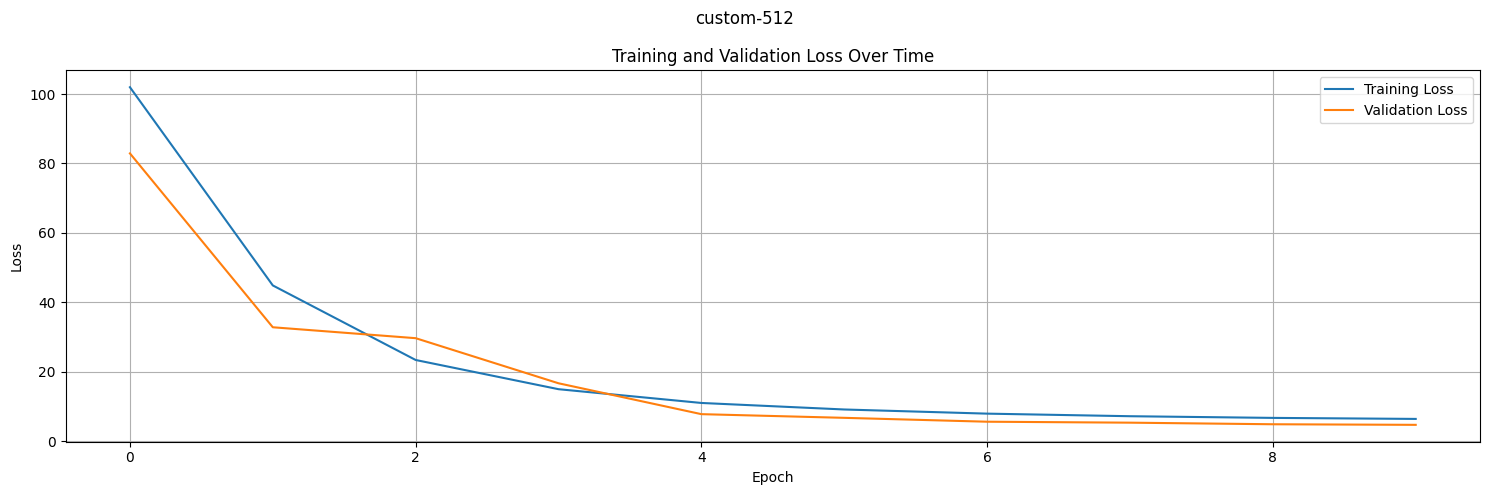

In [ ]:
custom512.plot_training_trend()

In [ ]:
score = custom512.evaluate(custom_test_ds)

print(f'Mean edit distance: {round(score[1], 3)}')
print(f'Symbol error rate: {round(score[2], 3)}')

274/274 [==============================] - 87s 303ms/step - loss: 0.0000e+00 - norm_edit_distance: 0.0476 - symbol_error_rate: 0.0728
Mean edit distance: 0.048
Symbol error rate: 0.073


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-F4', 'timeSignature-6/8', 'rest-quarter', 'rest-eighth', 'rest-eighth', 'note-G3_eighth', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-D3_eighth', 'note-C3_eighth', 'note-G3_quarter', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-D3_eighth', 'note-E3_eighth', 'note-C3_eighth', 'note-G3_eighth', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-D3_eighth', 'note-C3_eighth', 'note-B2_quarter', 'note-C3_eighth', 'barline', 'note-D3_quarter.', 'note-G2_quarter.', 'barline']
Predicted track:     ['clef-F4', 'timeSignature-6/8', 'rest-quarter', 'rest-eighth', 'rest-eighth', 'note-G3_eighth', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-D3_eighth', 'note-C3_eighth', 'note-G3_quarter', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-D3_eighth', 'note-E3_eighth', 'note-C3_eighth', 'note-G3_eighth', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-D3_eighth', 'note-C3_eighth', 'note-B2_quarte

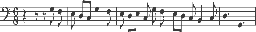


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-C1', 'keySignature-BbM', 'timeSignature-C/', 'multirest-1', 'barline', 'note-D5_quarter', 'note-D5_eighth', 'note-D5_eighth', 'note-D5_quarter', 'note-D5_quarter', 'barline', 'note-Eb5_quarter', 'note-D5_quarter', 'rest-quarter', 'note-Bb4_quarter', 'barline', 'note-C5_quarter', 'note-C5_quarter', 'gracenote-Bb4_eighth', 'note-A4_quarter.', 'note-Bb4_sixteenth', 'note-C5_sixteenth', 'barline', 'note-Bb4_quarter']
Predicted track:     ['clef-C1', 'keySignature-BbM', 'timeSignature-C/', 'multirest-1', 'barline', 'note-D5_quarter', 'note-D5_eighth', 'note-D5_eighth', 'note-D5_quarter', 'note-D5_quarter', 'barline', 'note-Eb5_quarter', 'note-D5_quarter', 'rest-quarter', 'note-Bb4_quarter', 'barline', 'note-C5_quarter', 'note-C5_quarter', 'gracenote-Bb4_eighth', 'note-A4_quarter.', 'note-Bb4_sixteenth', 'note-C5_sixteenth', 'barline', 'note-Bb4_quarter']
24 24


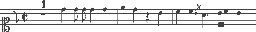


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-3/4', 'note-G4_quarter', 'note-G4_quarter', 'note-A4_eighth', 'note-G4_eighth', 'barline', 'note-F#4_quarter.', 'note-G4_eighth', 'note-A4_quarter', 'barline', 'note-B4_quarter', 'note-B4_quarter', 'note-C5_quarter', 'barline', 'note-B4_quarter.', 'note-A4_eighth', 'note-G4_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-3/4', 'note-G4_quarter', 'note-G4_quarter', 'note-A4_eighth', 'note-G4_eighth', 'barline', 'note-F#4_quarter.', 'note-G4_eighth', 'note-A4_quarter', 'barline', 'note-B4_quarter', 'note-B4_quarter', 'note-C5_quarter', 'barline', 'note-B4_quarter.', 'note-A4_eighth', 'note-G4_quarter', 'barline']
20 20


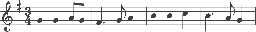


Edit distance: 0.147
Symbol error rate: 0.147
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-12/8', 'note-C5_eighth', 'barline', 'note-G5_eighth.', 'note-Ab5_sixteenth', 'note-G5_eighth', 'note-G5_quarter', 'note-G5_eighth', 'note-G5_thirty_second', 'note-Ab5_thirty_second', 'note-G5_sixteenth', 'note-F5_quarter', 'note-F5_thirty_second', 'note-G5_thirty_second', 'note-F5_sixteenth', 'note-Eb5_quarter', 'tie', 'barline', 'note-Eb5_eighth.', 'note-D5_sixteenth', 'note-F5_eighth', 'gracenote-G5_eighth', 'note-Ab5_eighth', 'gracenote-G5_eighth', 'note-F5_eighth', 'gracenote-Eb5_eighth', 'note-Db5_eighth', 'note-B4_quarter', 'note-C5_eighth', 'rest-quarter', 'rest-eighth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-6/8', 'note-C5_eighth', 'barline', 'note-G5_eighth.', 'note-Ab5_sixteenth', 'note-G5_eighth', 'note-G5_quarter', 'note-G5_eighth', 'note-G5_thirty_second', 'note-A5_thirty_second', 'note-G5_thirty_second', 'note-F5_quarte

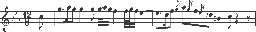


Edit distance: 0.2
Symbol error rate: 0.233
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'multirest-1', 'barline', 'note-Bb5_half.', 'note-G5_eighth.', 'note-Eb5_sixteenth', 'barline', 'note-D5_quarter', 'gracenote-C5_sixteenth', 'gracenote-D5_sixteenth', 'gracenote-Eb5_sixteenth', 'note-D5_eighth.', 'note-Eb5_sixteenth', 'note-F5_quarter', 'rest-quarter', 'barline', 'note-Bb5_half.', 'note-G5_eighth.', 'note-Eb5_sixteenth', 'barline', 'note-D5_quarter', 'gracenote-D5_sixteenth', 'gracenote-C5_sixteenth', 'gracenote-Eb5_sixteenth', 'note-D5_eighth.', 'note-Eb5_sixteenth', 'note-F5_quarter', 'rest-quarter']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'multirest-1', 'barline', 'note-Bb5_half', 'note-G5_eighth.', 'note-Eb5_sixteenth', 'barline', 'note-D5_quarter', 'gracenote-Eb5_eighth', 'gracenote-D5_sixteenth', 'gracenote-C5_sixteenth', 'note-D5_eighth.', 'note-Eb5_sixteenth', 'note-F5_quarter', 'rest-quarter', 'barline', 'note

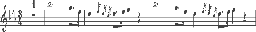


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-2/4', 'note-B4_eighth', 'note-B4_eighth', 'note-D5_eighth', 'note-D5_eighth', 'barline', 'note-G4_eighth', 'note-G4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'barline', 'note-E4_eighth', 'note-F#4_eighth', 'note-G4_eighth', 'note-A4_eighth', 'barline', 'note-B4_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-A4_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-2/4', 'note-B4_eighth', 'note-B4_eighth', 'note-D5_eighth', 'note-D5_eighth', 'barline', 'note-G4_eighth', 'note-G4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'barline', 'note-E4_eighth', 'note-F#4_eighth', 'note-G4_eighth', 'note-A4_eighth', 'barline', 'note-B4_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-A4_quarter', 'barline']
24 24


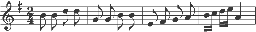


Edit distance: 0.091
Symbol error rate: 0.091
Original track:      ['clef-G2', 'keySignature-AM', 'timeSignature-C/', 'note-A4_quarter', 'barline', 'gracenote-D5_eighth', 'note-C#5_quarter', 'note-B4_eighth', 'note-A4_eighth', 'gracenote-D5_eighth', 'note-C#5_quarter', 'note-B4_eighth', 'note-A4_eighth', 'barline', 'note-E5_quarter', 'note-E4_half', 'note-E5_quarter', 'barline', 'note-A5_sixteenth', 'note-G#5_eighth.', 'note-B5_sixteenth', 'note-A5_eighth.']
Predicted track:     ['clef-G2', 'keySignature-AM', 'timeSignature-C', 'note-A4_quarter', 'barline', 'gracenote-D5_eighth', 'note-C#5_quarter', 'note-B4_eighth', 'note-A4_eighth', 'gracenote-D5_eighth', 'note-C#5_quarter', 'note-B4_eighth', 'note-A4_eighth', 'barline', 'note-E5_quarter', 'note-E4_half', 'note-E5_quarter', 'barline', 'note-A5_sixteenth', 'note-G5_eighth.', 'note-B5_sixteenth', 'note-A5_eighth.']
22 22


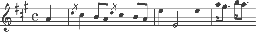


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'note-G4_quarter', 'note-F4_quarter', 'note-Eb4_quarter', 'barline', 'note-D4_half', 'note-Eb4_quarter', 'barline', 'note-F4_quarter', 'note-F4_quarter', 'note-Eb4_eighth.', 'note-G4_sixteenth', 'barline', 'note-Eb4_quarter', 'note-D4_quarter', 'rest-quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'note-G4_quarter', 'note-F4_quarter', 'note-Eb4_quarter', 'barline', 'note-D4_half', 'note-Eb4_quarter', 'barline', 'note-F4_quarter', 'note-F4_quarter', 'note-Eb4_eighth.', 'note-G4_sixteenth', 'barline', 'note-Eb4_quarter', 'note-D4_quarter', 'rest-quarter', 'barline']
19 19


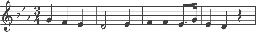


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-2/4', 'note-F4_eighth', 'barline', 'note-A4_eighth', 'note-A4_eighth', 'note-C5_eighth', 'note-C5_eighth', 'barline', 'note-C5_sixteenth', 'note-F5_sixteenth', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-C5_eighth', 'note-C5_eighth', 'barline', 'note-F4_eighth', 'note-F4_eighth', 'note-G4_eighth', 'note-G4_eighth', 'barline', 'note-A4_sixteenth', 'note-Bb4_sixteenth', 'note-A4_sixteenth', 'note-G4_sixteenth', 'note-F4_eighth', 'note-F4_eighth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-2/4', 'note-F4_eighth', 'barline', 'note-A4_eighth', 'note-A4_eighth', 'note-C5_eighth', 'note-C5_eighth', 'barline', 'note-C5_sixteenth', 'note-F5_sixteenth', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-C5_eighth', 'note-C5_eighth', 'barline', 'note-F4_eighth', 'note-F4_eighth', 'note-G4_eighth', 'note-G4_eighth', 'barline', 'note-A4_sixteenth', 'note-

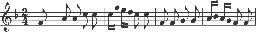


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-3/4', 'multirest-12', 'barline', 'note-A4_quarter', 'note-G4_quarter', 'note-F4_quarter', 'barline', 'note-G4_quarter.', 'note-C5_eighth', 'note-C5_eighth', 'note-E4_eighth', 'barline', 'note-F4_half', 'note-F4_quarter', 'barline', 'note-Bb4_quarter.', 'note-Bb4_eighth', 'note-Bb4_eighth', 'note-G4_eighth', 'barline', 'note-A4_half', 'rest-quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-3/4', 'multirest-12', 'barline', 'note-A4_quarter', 'note-G4_quarter', 'note-F4_quarter', 'barline', 'note-G4_quarter.', 'note-C5_eighth', 'note-C5_eighth', 'note-E4_eighth', 'barline', 'note-F4_half', 'note-F4_quarter', 'barline', 'note-Bb4_quarter.', 'note-Bb4_eighth', 'note-Bb4_eighth', 'note-G4_eighth', 'barline', 'note-A4_half', 'rest-quarter', 'barline']
25 25


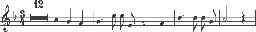


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-EM', 'timeSignature-C', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'barline', 'note-B4_eighth', 'note-B4_eighth', 'note-A4_eighth', 'note-A4_eighth', 'note-A4_eighth', 'note-A4_eighth', 'note-G#4_eighth', 'note-G#4_eighth', 'barline', 'note-F#4_eighth', 'note-F#4_eighth', 'note-F#4_eighth', 'note-F#4_eighth', 'note-E4_quarter', 'rest-eighth_fermata']
Predicted track:     ['clef-G2', 'keySignature-EM', 'timeSignature-C', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'barline', 'note-B4_eighth', 'note-B4_eighth', 'note-A4_eighth', 'note-A4_eighth', 'note-A4_eighth', 'note-A4_eighth', 'note-G#4_eighth', 'note-G#4_eighth', 'barline', 'note-F#4_eighth', 'note-F#4_eighth', 'note-F#4_eighth', 'note-F#4_eighth

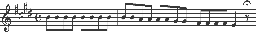


Edit distance: 0.094
Symbol error rate: 0.094
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-2/4', 'note-C5_eighth', 'barline', 'note-F5_eighth', 'note-F4_eighth', 'note-F4_eighth', 'note-F4_eighth', 'barline', 'note-F4_quarter', 'rest-eighth', 'rest-thirty_second', 'note-G4_thirty_second', 'note-A4_thirty_second', 'note-B4_thirty_second', 'barline', 'note-C5_eighth', 'note-C4_eighth', 'note-C4_eighth', 'note-C4_eighth', 'barline', 'note-C4_quarter', 'rest-eighth', 'rest-thirty_second', 'note-C4_thirty_second', 'note-D4_thirty_second', 'note-E4_thirty_second', 'barline', 'note-F4_eighth', 'note-F4_eighth', 'note-F4_eighth']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-2/4', 'note-C5_eighth', 'barline', 'note-F5_eighth', 'note-F4_eighth', 'note-F4_eighth', 'note-F4_eighth', 'barline', 'note-F4_quarter', 'rest-eighth', 'rest-sixteenth', 'note-G4_thirty_second', 'note-A4_thirty_second', 'note-Bb4_thirty_second', 'barline', 'note-C5_eighth', 'note

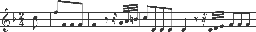


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'note-Bb3_eighth.', 'note-Bb3_sixteenth', 'barline', 'note-Eb4_quarter', 'note-F4_quarter', 'note-G4_eighth.', 'note-Ab4_sixteenth', 'barline', 'note-G4_quarter', 'note-F4_quarter', 'note-Bb4_eighth.', 'note-Bb4_sixteenth', 'barline', 'note-Eb5_quarter', 'note-F5_quarter', 'note-G5_eighth.', 'note-G5_sixteenth', 'barline', 'note-F5_quarter', 'rest-quarter']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'note-Bb3_eighth.', 'note-Bb3_sixteenth', 'barline', 'note-Eb4_quarter', 'note-F4_quarter', 'note-G4_eighth.', 'note-Ab4_sixteenth', 'barline', 'note-G4_quarter', 'note-F4_quarter', 'note-Bb4_eighth.', 'note-Bb4_sixteenth', 'barline', 'note-Eb5_quarter', 'note-F5_quarter', 'note-G5_eighth.', 'note-G5_sixteenth', 'barline', 'note-F5_quarter', 'rest-quarter']
23 23


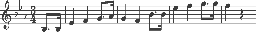


Edit distance: 0.071
Symbol error rate: 0.071
Original track:      ['clef-C1', 'keySignature-FM', 'timeSignature-12/8', 'note-F5_sixteenth', 'note-C5_sixteenth', 'note-A4_sixteenth', 'note-F4_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-F4_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 'note-Bb4_sixteenth', 'note-F4_sixteenth', 'note-E4_sixteenth', 'note-F4_sixteenth', 'note-Bb4_sixteenth', 'note-D#4_sixteenth', 'note-F4_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-Bb4_sixteenth', 'note-A4_sixteenth', 'barline']
Predicted track:     ['clef-C1', 'keySignature-FM', 'timeSignature-6/8', 'note-F5_sixteenth', 'note-C5_sixteenth', 'note-A4_sixteenth', 'note-F4_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-F4_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 'note-Bb4_si

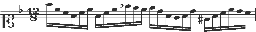


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-F4', 'keySignature-FM', 'timeSignature-C', 'rest-eighth', 'note-F3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-E3_sixteenth', 'note-D3_sixteenth', 'note-E3_eighth', 'note-C3_eighth', 'note-D3_eighth', 'note-D4_eighth', 'note-D4_eighth', 'note-D4_eighth', 'barline', 'note-C4_eighth', 'note-C4_sixteenth', 'note-Bb3_sixteenth', 'note-C4_eighth', 'note-A3_eighth', 'note-Bb3_eighth', 'note-Bb3_sixteenth', 'note-A3_sixteenth', 'note-Bb3_eighth', 'note-G3_eighth', 'barline', 'note-A3_eighth', 'note-F3_eighth', 'note-C4_eighth', 'note-C3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'barline']
Predicted track:     ['clef-F4', 'keySignature-FM', 'timeSignature-C', 'rest-eighth', 'note-F3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-E3_sixteenth', 'note-D3_sixteenth', 'note-E3_eighth', 'note-C3_eighth', 'note-D3_eighth', 

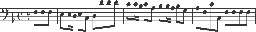


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'note-D4_quarter', 'rest-eighth', 'rest-sixteenth', 'note-D4_sixteenth', 'note-F#4_eighth.', 'note-D4_sixteenth', 'note-A4_eighth.', 'note-F#4_sixteenth', 'barline', 'note-D5_quarter', 'rest-eighth', 'rest-sixteenth', 'note-A4_sixteenth', 'note-D5_eighth.', 'note-A4_sixteenth', 'note-F#5_eighth.', 'note-D5_sixteenth', 'barline', 'note-A5_quarter']
Predicted track:     ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'note-D4_quarter', 'rest-eighth', 'rest-sixteenth', 'note-D4_sixteenth', 'note-F#4_eighth.', 'note-D4_sixteenth', 'note-A4_eighth.', 'note-F#4_sixteenth', 'barline', 'note-D5_quarter', 'rest-eighth', 'rest-sixteenth', 'note-A4_sixteenth', 'note-D5_eighth.', 'note-A4_sixteenth', 'note-F#5_eighth.', 'note-D5_sixteenth', 'barline', 'note-A5_quarter']
22 22


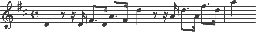


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-C', 'note-G5_quarter', 'tie', 'note-G5_eighth', 'note-F5_thirty_second', 'note-Eb5_thirty_second', 'note-D5_thirty_second', 'note-C5_thirty_second', 'barline', 'note-Ab5_eighth', 'note-G5_eighth', 'rest-sixteenth', 'note-G5_sixteenth', 'note-Eb5_sixteenth', 'note-C5_sixteenth', 'barline', 'note-C5_sixteenth', 'note-B4_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-F5_sixteenth', 'note-Eb5_sixteenth']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-C', 'note-G5_quarter', 'tie', 'note-G5_eighth', 'note-F5_thirty_second', 'note-Eb5_thirty_second', 'note-D5_thirty_second', 'note-C5_thirty_second', 'barline', 'note-Ab5_eighth', 'note-G5_eighth', 'rest-sixteenth', 'note-G5_sixteenth', 'note-Eb5_sixteenth', 'note-C5_sixteenth', 'barline', 'note-C5_sixteenth', 'note-B4_sixteenth', 'note-D5_sixteenth', 'note-C5

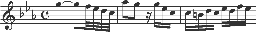


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'timeSignature-C', 'note-G4_half.', 'note-G4_quarter', 'barline', 'note-E5_quarter', 'note-E5_quarter', 'note-E5_quarter', 'note-D5_quarter', 'barline', 'note-C5_half', 'note-C5_quarter', 'note-D5_quarter', 'barline', 'note-B4_half', 'note-B4_quarter.', 'note-G4_eighth', 'barline']
Predicted track:     ['clef-G2', 'timeSignature-C', 'note-G4_half.', 'note-G4_quarter', 'barline', 'note-E5_quarter', 'note-E5_quarter', 'note-E5_quarter', 'note-D5_quarter', 'barline', 'note-C5_half', 'note-C5_quarter', 'note-D5_quarter', 'barline', 'note-B4_half', 'note-B4_quarter.', 'note-G4_eighth', 'barline']
18 18


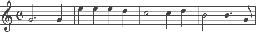


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-BbM', 'timeSignature-2/4', 'note-F4_eighth', 'note-Bb4_eighth', 'note-Bb4_eighth', 'note-Bb4_eighth', 'barline', 'note-C5_eighth', 'note-C5_sixteenth.', 'note-D5_thirty_second', 'note-Bb4_eighth', 'rest-eighth', 'barline', 'note-C5_eighth', 'note-C5_sixteenth.', 'note-D5_thirty_second', 'note-Bb4_eighth', 'note-Eb5_eighth', 'barline', 'note-D5_eighth', 'note-C5_eighth', 'note-F5_sixteenth', 'note-Eb5_sixteenth', 'note-C5_sixteenth', 'note-A4_sixteenth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-BbM', 'timeSignature-2/4', 'note-F4_eighth', 'note-Bb4_eighth', 'note-Bb4_eighth', 'note-Bb4_eighth', 'barline', 'note-C5_eighth', 'note-C5_sixteenth.', 'note-D5_thirty_second', 'note-Bb4_eighth', 'rest-eighth', 'barline', 'note-C5_eighth', 'note-C5_sixteenth.', 'note-D5_thirty_second', 'note-Bb4_eighth', 'note-Eb5_eighth', 'barline', 'note-D5_eighth', 'note-C5_eighth', 'note-F5_sixteenth', 

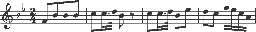


Edit distance: 0.038
Symbol error rate: 0.038
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-C', 'note-G5_quarter', 'note-C5_eighth.', 'note-B4_sixteenth', 'note-C5_eighth.', 'note-D5_thirty_second', 'note-Eb5_thirty_second', 'note-D5_eighth', 'note-Eb5_eighth', 'barline', 'gracenote-D5_sixteenth', 'gracenote-Eb5_sixteenth', 'note-F5_eighth.', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 'note-Eb5_sixteenth', 'gracenote-C5_eighth', 'note-B4_eighth.', 'note-C5_thirty_second', 'note-D5_thirty_second', 'note-C5_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-C', 'note-G5_quarter', 'note-C5_eighth.', 'note-B4_sixteenth', 'note-C5_eighth.', 'note-D5_thirty_second', 'note-Eb5_thirty_second', 'note-D5_eighth', 'note-Eb5_eighth', 'barline', 'gracenote-D5_sixteenth', 'gracenote-Eb5_eighth', 'note-F5_eighth.', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 

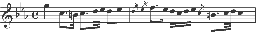


Edit distance: 0.125
Symbol error rate: 0.125
Original track:      ['clef-C2', 'keySignature-FM', 'timeSignature-4/2', 'note-F4_half', 'note-F4_quarter', 'note-F4_quarter', 'note-F4_half.', 'note-A4_quarter', 'barline', 'note-F4_quarter', 'note-Bb4_half', 'note-Bb4_quarter', 'note-Bb4_half', 'note-D4_half', 'barline', 'rest-whole']
Predicted track:     ['clef-C3', 'keySignature-FM', 'timeSignature-3/4', 'note-F4_half', 'note-F4_quarter', 'note-F4_quarter', 'note-F4_half.', 'note-A4_quarter', 'barline', 'note-F4_quarter', 'note-Bb4_half', 'note-Bb4_quarter', 'note-Bb4_half', 'note-D4_half', 'barline', 'rest-whole']
16 16


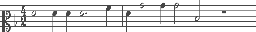


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-F4', 'timeSignature-C/', 'note-D3_half', 'note-A2_half', 'barline', 'note-D3_half', 'note-C3_half', 'barline', 'note-F3_half', 'note-C3_half', 'barline', 'note-D3_half', 'note-A2_half', 'barline']
Predicted track:     ['clef-F4', 'timeSignature-C/', 'note-D3_half', 'note-A2_half', 'barline', 'note-D3_half', 'note-C3_half', 'barline', 'note-F3_half', 'note-C3_half', 'barline', 'note-D3_half', 'note-A2_half', 'barline']
14 14


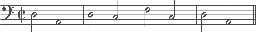


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-C4', 'timeSignature-C', 'rest-quarter', 'rest-quarter', 'rest-quarter', 'rest-eighth', 'note-A3_eighth', 'barline', 'note-C4_eighth', 'note-C4_eighth', 'rest-eighth', 'note-C4_sixteenth', 'note-D4_sixteenth', 'note-E4_quarter', 'note-D4_eighth', 'note-C4_eighth', 'barline', 'note-F4_quarter', 'rest-quarter', 'rest-half', 'barline', 'multirest-1', 'barline']
Predicted track:     ['clef-C4', 'timeSignature-C', 'rest-quarter', 'rest-quarter', 'rest-quarter', 'rest-eighth', 'note-A3_eighth', 'barline', 'note-C4_eighth', 'note-C4_eighth', 'rest-eighth', 'note-C4_sixteenth', 'note-D4_sixteenth', 'note-E4_quarter', 'note-D4_eighth', 'note-C4_eighth', 'barline', 'note-F4_quarter', 'rest-quarter', 'rest-half', 'barline', 'multirest-1', 'barline']
23 23


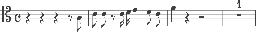


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-BbM', 'timeSignature-3/8', 'note-Bb5_quarter', 'rest-eighth', 'barline', 'note-A5_quarter', 'rest-eighth', 'barline', 'note-G5_quarter', 'rest-eighth', 'barline', 'rest-eighth', 'note-F5_sixteenth', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-BbM', 'timeSignature-3/8', 'note-Bb5_quarter', 'rest-eighth', 'barline', 'note-A5_quarter', 'rest-eighth', 'barline', 'note-G5_quarter', 'rest-eighth', 'barline', 'rest-eighth', 'note-F5_sixteenth', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'barline']
18 18


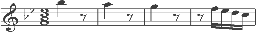


Edit distance: 0.095
Symbol error rate: 0.095
Original track:      ['clef-C1', 'keySignature-DM', 'timeSignature-C', 'multirest-33', 'barline', 'note-D4_half', 'rest-quarter', 'note-D4_quarter', 'barline', 'note-G4_half', 'note-G4_quarter', 'note-G4_quarter', 'barline', 'note-F#4_quarter.', 'note-D4_eighth', 'note-D4_quarter', 'rest-quarter', 'barline', 'multirest-5', 'barline', 'note-D4_half']
Predicted track:     ['clef-C1', 'keySignature-DM', 'timeSignature-C', 'multirest-12', 'barline', 'note-D4_half', 'rest-quarter', 'note-D4_quarter', 'barline', 'note-G4_half', 'note-G4_quarter', 'note-G4_quarter', 'barline', 'note-F#4_quarter.', 'note-D4_eighth', 'note-D4_quarter', 'rest-quarter', 'barline', 'multirest-3', 'barline', 'note-D4_half']
21 21


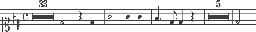


Edit distance: 0.05
Symbol error rate: 0.05
Original track:      ['clef-C4', 'keySignature-FM', 'timeSignature-C', 'multirest-3', 'barline', 'rest-half', 'rest-quarter', 'note-C4_eighth', 'note-F4_eighth', 'barline', 'note-F4_eighth', 'note-C4_eighth', 'note-A3_eighth', 'note-Bb3_eighth', 'note-C4_eighth', 'note-F4_eighth', 'note-A3_eighth', 'note-Bb3_eighth', 'barline', 'note-C4_eighth']
Predicted track:     ['clef-C4', 'keySignature-FM', 'timeSignature-C', 'multirest-5', 'barline', 'rest-half', 'rest-quarter', 'note-C4_eighth', 'note-F4_eighth', 'barline', 'note-F4_eighth', 'note-C4_eighth', 'note-A3_eighth', 'note-Bb3_eighth', 'note-C4_eighth', 'note-F4_eighth', 'note-A3_eighth', 'note-Bb3_eighth', 'barline', 'note-C4_eighth']
20 20


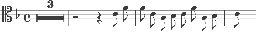


Edit distance: 0.062
Symbol error rate: 0.062
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-C', 'multirest-3', 'barline', 'rest-half', 'rest-quarter', 'note-B4_eighth.', 'note-E5_sixteenth', 'barline', 'note-E5_quarter.', 'note-E4_eighth', 'note-G4_eighth', 'note-F#4_eighth', 'note-E4_eighth', 'note-D#4_eighth', 'barline', 'note-E4_eighth.', 'note-D#4_sixteenth', 'note-E4_eighth', 'note-F#4_eighth', 'note-B3_quarter', 'note-B4_eighth.', 'note-A4_sixteenth', 'barline', 'note-A4_eighth', 'note-G4_eighth', 'note-F#4_eighth', 'note-E4_eighth', 'note-D#4_quarter', 'note-E4_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-C', 'multirest-3', 'barline', 'rest-half', 'rest-quarter', 'note-B4_eighth.', 'note-E5_sixteenth', 'barline', 'note-E5_quarter.', 'note-E4_eighth', 'note-G4_eighth', 'note-F#4_eighth', 'note-E4_eighth', 'note-D#4_eighth', 'barline', 'note-E4_eighth.', 'note-D4_sixteenth', 'note-E4_eighth', 'note-F#4_eighth', 'note

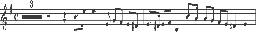


Edit distance: 0.034
Symbol error rate: 0.034
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-C/', 'note-B4_quarter', 'note-C5_eighth', 'note-D5_eighth', 'barline', 'note-G4_half', 'note-D5_quarter', 'note-E5_eighth', 'note-F#5_eighth', 'barline', 'note-G5_eighth', 'note-F#5_eighth', 'note-G5_eighth', 'note-D5_eighth', 'note-E5_eighth', 'note-D5_eighth', 'note-E5_eighth', 'note-C5_eighth', 'barline', 'note-D5_quarter', 'note-B4_quarter', 'note-D5_eighth', 'note-C5_eighth', 'note-B4_eighth', 'note-A4_eighth', 'barline', 'note-G4_half']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-C', 'note-B4_quarter', 'note-C5_eighth', 'note-D5_eighth', 'barline', 'note-G4_half', 'note-D5_quarter', 'note-E5_eighth', 'note-F#5_eighth', 'barline', 'note-G5_eighth', 'note-F#5_eighth', 'note-G5_eighth', 'note-D5_eighth', 'note-E5_eighth', 'note-D5_eighth', 'note-E5_eighth', 'note-C5_eighth', 'barline', 'note-D5_quarter', 'note-B4_quarter', 'note-D5_eighth', 'note-C

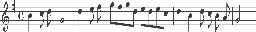


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'note-D4_quarter', 'note-A4_quarter', 'note-G4_quarter', 'note-F#4_quarter', 'barline', 'note-G4_whole', 'barline', 'rest-quarter', 'note-G4_eighth', 'note-F#4_sixteenth', 'note-G4_sixteenth', 'note-A4_eighth', 'note-G4_eighth', 'note-F#4_eighth', 'note-G4_eighth', 'barline', 'note-A4_quarter', 'note-F#4_quarter', 'note-F#4_quarter', 'note-F#4_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'note-D4_quarter', 'note-A4_quarter', 'note-G4_quarter', 'note-F#4_quarter', 'barline', 'note-G4_whole', 'barline', 'rest-quarter', 'note-G4_eighth', 'note-F#4_sixteenth', 'note-G4_sixteenth', 'note-A4_eighth', 'note-G4_eighth', 'note-F#4_eighth', 'note-G4_eighth', 'barline', 'note-A4_quarter', 'note-F#4_quarter', 'note-F#4_quarter', 'note-F#4_quarter', 'barline']
24 24


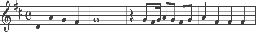


Edit distance: 0.2
Symbol error rate: 0.2
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-3/1', 'rest-whole', 'rest-whole', 'note-Bb4_whole', 'note-Bb4_double_whole', 'note-D5_whole', 'note-C5_double_whole', 'note-Bb4_whole', 'note-C5_whole.', 'note-D5_half', 'note-E5_whole', 'note-F5_double_whole', 'note-F5_whole']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-3/2', 'rest-whole', 'rest-whole', 'note-Bb4_whole', 'note-Bb4_whole', 'note-D5_whole', 'note-C5_double_whole', 'note-Bb4_whole', 'note-C5_whole.', 'note-D5_half', 'note-E5_whole', 'note-F5_whole', 'note-F5_whole']
15 15


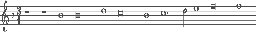


Edit distance: 0.053
Symbol error rate: 0.053
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-C', 'note-D5_quarter', 'note-A4_quarter', 'note-Bb4_eighth', 'note-A4_eighth', 'note-A4_quarter', 'barline', 'note-G4_quarter.', 'note-A4_eighth', 'note-F4_eighth', 'note-D4_eighth', 'note-F5_eighth', 'note-Eb5_eighth', 'barline', 'note-D5_eighth', 'note-E5_eighth', 'note-F5_quarter']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-C', 'note-D5_quarter', 'note-A4_quarter', 'note-Bb4_eighth', 'note-A4_eighth', 'note-A4_quarter', 'barline', 'note-G4_quarter.', 'note-A4_eighth', 'note-F4_eighth', 'note-D4_eighth', 'note-F5_eighth', 'note-E5_eighth', 'barline', 'note-D5_eighth', 'note-E5_eighth', 'note-F5_quarter']
19 19


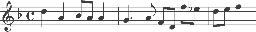


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G1', 'timeSignature-C', 'note-C5_quarter.', 'note-G5_eighth', 'note-E5_quarter', 'note-D5_eighth', 'note-C5_eighth', 'barline', 'note-F5_quarter.', 'note-F5_eighth', 'note-F5_quarter.', 'note-G5_eighth', 'barline', 'note-E5_quarter.', 'note-E5_eighth', 'note-D5_quarter', 'note-C5_eighth', 'note-B4_eighth', 'barline', 'note-C5_quarter.', 'note-C5_eighth', 'note-C5_quarter.', 'note-B4_eighth', 'barline', 'note-A4_half']
Predicted track:     ['clef-G1', 'timeSignature-C', 'note-C5_quarter.', 'note-G5_eighth', 'note-E5_quarter', 'note-D5_eighth', 'note-C5_eighth', 'barline', 'note-F5_quarter.', 'note-F5_eighth', 'note-F5_quarter.', 'note-G5_eighth', 'barline', 'note-E5_quarter.', 'note-E5_eighth', 'note-D5_quarter', 'note-C5_eighth', 'note-B4_eighth', 'barline', 'note-C5_quarter.', 'note-C5_eighth', 'note-C5_quarter.', 'note-B4_eighth', 'barline', 'note-A4_half']
25 25


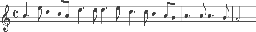


Edit distance: 0.231
Symbol error rate: 0.231
Original track:      ['clef-C4', 'keySignature-FM', 'timeSignature-3/1', 'rest-whole', 'rest-whole', 'note-F3_whole', 'note-F3_double_whole', 'note-F3_whole', 'note-A3_double_whole', 'note-Bb3_whole', 'note-C4_whole', 'note-D4_double_whole', 'note-C4_double_whole']
Predicted track:     ['clef-C4', 'keySignature-FM', 'timeSignature-4/2', 'rest-whole', 'rest-whole', 'note-F3_whole', 'note-F3_double_whole', 'note-F3_whole', 'note-G3_double_whole', 'note-G3_whole', 'note-C4_whole', 'note-D4_double_whole', 'note-C4_double_whole']
13 13


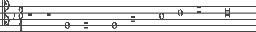


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-C1', 'keySignature-DM', 'timeSignature-C', 'multirest-7', 'barline', 'rest-eighth', 'note-A4_quarter', 'rest-eighth', 'note-A4_eighth', 'note-D5_eighth', 'note-C#5_thirty_second', 'note-B4_thirty_second', 'note-C#5_eighth', 'barline', 'note-D5_quarter', 'note-F#4_half', 'note-G#4_eighth', 'note-A4_eighth', 'barline', 'note-A4_quarter.', 'note-G#4_eighth', 'note-A4_half', 'barline']
Predicted track:     ['clef-C1', 'keySignature-DM', 'timeSignature-C', 'multirest-7', 'barline', 'rest-eighth', 'note-A4_quarter', 'rest-eighth', 'note-A4_eighth', 'note-D5_eighth', 'note-C#5_thirty_second', 'note-B4_thirty_second', 'note-C#5_eighth', 'barline', 'note-D5_quarter', 'note-F#4_half', 'note-G#4_eighth', 'note-A4_eighth', 'barline', 'note-A4_quarter.', 'note-G#4_eighth', 'note-A4_half', 'barline']
23 23


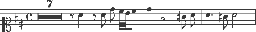


Edit distance: 0.065
Symbol error rate: 0.065
Original track:      ['clef-G2', 'keySignature-BbM', 'timeSignature-C/', 'note-G5_sixteenth', 'note-F5_sixteenth', 'note-E5_sixteenth', 'note-F5_sixteenth', 'barline', 'note-Bb5_half', 'note-A5_quarter', 'note-G5_sixteenth', 'note-F5_sixteenth', 'note-E5_sixteenth', 'note-F5_sixteenth', 'barline', 'note-Bb5_half', 'note-A5_quarter', 'note-G5_sixteenth', 'note-F5_sixteenth', 'note-E5_sixteenth', 'note-F5_sixteenth', 'barline', 'note-Bb5_eighth.', 'note-A5_sixteenth', 'note-A5_eighth.', 'note-A5_sixteenth', 'note-Bb5_eighth.', 'note-A5_sixteenth', 'note-Bb5_eighth.', 'note-D6_sixteenth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-BbM', 'timeSignature-C', 'note-G5_sixteenth', 'note-F5_sixteenth', 'note-E5_sixteenth', 'note-F5_sixteenth', 'barline', 'note-Bb5_half', 'note-A5_quarter', 'note-G5_sixteenth', 'note-F5_sixteenth', 'note-Eb5_sixteenth', 'note-F5_sixteenth', 'barline', 'note-Bb5_half', 'note-A5_quarter', 'note-G5_sixte

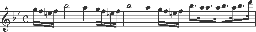


Edit distance: 0.043
Symbol error rate: 0.043
Original track:      ['clef-C1', 'keySignature-FM', 'timeSignature-6/8', 'multirest-8', 'barline', 'rest-quarter', 'rest-eighth', 'rest-eighth.', 'note-A4_sixteenth', 'note-Bb4_eighth', 'barline', 'note-C4_eighth.', 'note-D4_sixteenth', 'note-C4_eighth', 'note-C4_quarter', 'note-C4_eighth', 'barline', 'note-C#4_quarter', 'note-D4_eighth', 'note-D4_eighth.', 'note-Bb3_sixteenth', 'note-A3_eighth', 'barline']
Predicted track:     ['clef-C1', 'keySignature-FM', 'timeSignature-6/8', 'multirest-3', 'barline', 'rest-quarter', 'rest-eighth', 'rest-eighth.', 'note-A4_sixteenth', 'note-Bb4_eighth', 'barline', 'note-C4_eighth.', 'note-D4_sixteenth', 'note-C4_eighth', 'note-C4_quarter', 'note-C4_eighth', 'barline', 'note-C#4_quarter', 'note-D4_eighth', 'note-D4_eighth.', 'note-Bb3_sixteenth', 'note-A3_eighth', 'barline']
23 23


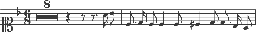


Edit distance: 0.143
Symbol error rate: 0.643
Original track:      ['clef-C1', 'timeSignature-3/2', 'note-D5_half', 'barline', 'note-A4_half.', 'note-G4_quarter', 'note-F4_quarter', 'note-E4_quarter', 'barline', 'gracenote-E4_eighth', 'note-F4_quarter', 'note-F4_eighth', 'note-D4_eighth', 'note-B4_half', 'gracenote-G4_eighth', 'note-A4_quarter', 'note-D5_quarter', 'barline', 'note-C#5_half', 'note-C5_quarter', 'note-A4_eighth', 'note-A4_eighth', 'note-D5_quarter', 'note-D5_eighth', 'note-E5_eighth', 'barline', 'gracenote-E5_sixteenth', 'note-F5_half.']
Predicted track:     ['clef-C1', 'timeSignature-3/2', 'note-D5_half', 'barline', 'note-A4_half.', 'note-G4_quarter', 'note-F4_quarter', 'note-E4_quarter', 'barline', 'note-F#4_quarter', 'note-F4_eighth', 'note-D4_eighth', 'note-B4_half', 'gracenote-G4_eighth', 'note-A4_quarter', 'note-D5_quarter', 'barline', 'note-C#5_half', 'note-C5_quarter', 'note-A4_eighth', 'note-A4_eighth', 'note-D5_quarter', 'note-D5_eighth', 'note-E5_eighth', 'ba

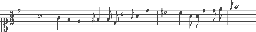


Edit distance: 0.15
Symbol error rate: 0.525
Original track:      ['clef-C1', 'keySignature-EbM', 'timeSignature-C', 'rest-eighth', 'barline', 'multirest-7', 'barline', 'rest-quarter', 'rest-eighth', 'note-Bb4_eighth', 'note-Db5_quarter', 'note-C5_eighth', 'note-Eb5_eighth', 'barline', 'note-C5_eighth', 'note-Bb4_eighth', 'rest-eighth', 'note-Eb5_eighth', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-F5_eighth', 'tie', 'note-F5_sixteenth', 'gracenote-Eb5_sixteenth', 'note-D5_sixteenth', 'gracenote-C5_sixteenth', 'note-Bb4_sixteenth', 'note-Ab4_sixteenth', 'barline', 'note-Ab4_eighth', 'note-G4_eighth', 'rest-eighth', 'note-Bb4_eighth', 'note-Db5_quarter', 'note-C5_eighth', 'note-Eb5_eighth', 'barline', 'note-C5_eighth', 'note-Bb4_eighth', 'rest-eighth']
Predicted track:     ['clef-C1', 'keySignature-EbM', 'timeSignature-C', 'rest-eighth', 'barline', 'multirest-7', 'barline', 'rest-quarter', 'rest-eighth', 'note-Bb4_eighth', 'note-D5_quarter', 'note-C5_eighth', 'note-Eb5_eighth', 'b

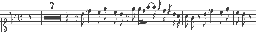


Edit distance: 0.061
Symbol error rate: 0.061
Original track:      ['clef-C1', 'keySignature-EM', 'timeSignature-6/8', 'multirest-14', 'barline', 'note-B4_quarter', 'note-C#5_eighth', 'barline', 'note-B4_thirty_second', 'note-A4_thirty_second', 'note-G#4_eighth.', 'note-B4_eighth', 'note-A4_thirty_second', 'note-G#4_thirty_second', 'note-F#4_eighth.', 'note-A4_eighth', 'barline', 'gracenote-B4_eighth', 'note-A4_quarter', 'note-G#4_eighth', 'note-B4_quarter', 'note-E5_eighth', 'barline', 'note-D#5_eighth', 'note-G#4_eighth', 'note-C#5_eighth', 'note-B4_eighth', 'note-E4_eighth', 'note-A4_eighth', 'barline', 'gracenote-B4_eighth', 'note-A4_quarter', 'note-G#4_eighth']
Predicted track:     ['clef-C1', 'keySignature-EM', 'timeSignature-6/8', 'multirest-24', 'barline', 'note-B4_quarter', 'note-C#5_eighth', 'barline', 'note-B4_thirty_second', 'note-A4_thirty_second', 'note-G#4_eighth.', 'note-B4_eighth', 'note-A4_thirty_second', 'note-G#4_thirty_second', 'note-F#4_eighth.', 'note-A4_eighth'

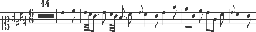


Edit distance: 0.043
Symbol error rate: 0.435
Original track:      ['clef-C1', 'keySignature-GM', 'timeSignature-3/2', 'rest-half', 'rest-half', 'rest-quarter', 'note-D4_quarter', 'barline', 'note-G4_half.', 'note-A4_quarter', 'note-B4_quarter.', 'note-C5_eighth', 'barline', 'note-A4_whole', 'note-D5_quarter.', 'note-D5_eighth', 'barline', 'note-D5_half.', 'note-C5_quarter', 'note-C5_quarter.', 'note-B4_eighth', 'barline', 'note-B4_whole']
Predicted track:     ['clef-C1', 'keySignature-GM', 'timeSignature-3/2', 'rest-half', 'rest-half', 'rest-quarter', 'note-D4_quarter', 'barline', 'note-G4_half.', 'note-A4_quarter', 'note-B4_quarter.', 'note-C5_eighth', 'barline', 'note-A4_whole', 'barline', 'note-D5_quarter.', 'note-D5_eighth', 'barline', 'note-D5_half.', 'note-C5_quarter', 'note-C5_quarter.', 'note-B4_eighth', 'barline', 'note-B4_whole']
23 24


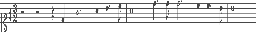


Edit distance: 0.03
Symbol error rate: 0.03
Original track:      ['clef-G2', 'keySignature-AM', 'timeSignature-3/8', 'note-C#5_sixteenth', 'note-D5_sixteenth', 'barline', 'note-E5_eighth', 'note-A4_eighth', 'note-B4_eighth', 'barline', 'note-C#5_sixteenth', 'note-B4_sixteenth', 'note-A4_eighth', 'note-A5_eighth', 'barline', 'note-A5_eighth', 'note-G#5_sixteenth', 'note-F#5_sixteenth', 'note-E5_sixteenth', 'note-D5_sixteenth', 'barline', 'note-C#5_sixteenth', 'note-B4_sixteenth', 'note-A4_eighth', 'note-E5_eighth', 'barline', 'note-F#5_sixteenth', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-F#5_sixteenth', 'note-D5_sixteenth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-AM', 'timeSignature-3/8', 'note-C#5_sixteenth', 'note-D5_sixteenth', 'barline', 'note-E5_eighth', 'note-A4_eighth', 'note-B4_eighth', 'barline', 'note-C#5_sixteenth', 'note-B4_sixteenth', 'note-A4_eighth', 'note-A5_eighth', 'barline', 'note-A5_eighth', 'note-G5_sixteenth', 'note-F#

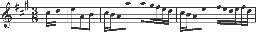


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-C1', 'keySignature-GM', 'timeSignature-C', 'note-G4_half', 'note-B4_eighth', 'note-A4_eighth', 'note-B4_eighth', 'note-G4_eighth', 'barline', 'note-A4_eighth', 'note-B4_sixteenth', 'note-C5_sixteenth', 'note-D5_eighth', 'note-C5_eighth', 'note-B4_quarter', 'rest-eighth', 'note-E5_eighth', 'barline', 'note-E5_eighth', 'note-D5_eighth', 'rest-eighth', 'note-C5_eighth', 'gracenote-D5_eighth', 'note-C5_eighth', 'note-B4_eighth', 'rest-eighth']
Predicted track:     ['clef-C1', 'keySignature-GM', 'timeSignature-C', 'note-G4_half', 'note-B4_eighth', 'note-A4_eighth', 'note-B4_eighth', 'note-G4_eighth', 'barline', 'note-A4_eighth', 'note-B4_sixteenth', 'note-C5_sixteenth', 'note-D5_eighth', 'note-C5_eighth', 'note-B4_quarter', 'rest-eighth', 'note-E5_eighth', 'barline', 'note-E5_eighth', 'note-D5_eighth', 'rest-eighth', 'note-C5_eighth', 'gracenote-D5_eighth', 'note-C5_eighth', 'note-B4_eighth', 'rest-eighth']
26 26


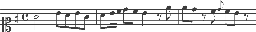


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'multirest-1', 'barline', 'rest-quarter', 'rest-eighth', 'note-C#5_sixteenth', 'note-D5_sixteenth', 'note-E5_eighth', 'note-A4_eighth', 'note-F#5_sixteenth', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-C#5_sixteenth', 'barline', 'note-B4_eighth', 'note-E4_eighth', 'rest-eighth', 'note-G#4_sixteenth', 'note-A4_sixteenth', 'note-B4_eighth']
Predicted track:     ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'multirest-1', 'barline', 'rest-quarter', 'rest-eighth', 'note-C#5_sixteenth', 'note-D5_sixteenth', 'note-E5_eighth', 'note-A4_eighth', 'note-F#5_sixteenth', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-C#5_sixteenth', 'barline', 'note-B4_eighth', 'note-E4_eighth', 'rest-eighth', 'note-G#4_sixteenth', 'note-A4_sixteenth', 'note-B4_eighth']
22 22


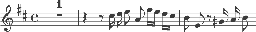


Edit distance: 0.152
Symbol error rate: 0.152
Original track:      ['clef-C1', 'keySignature-AM', 'timeSignature-C/', 'multirest-29', 'barline', 'note-A4_eighth', 'note-C#5_eighth', 'note-C#5_eighth', 'note-E5_eighth', 'gracenote-F#5_sixteenth', 'note-E5_eighth', 'note-D5_eighth', 'gracenote-E5_sixteenth', 'note-D5_eighth', 'note-C#5_eighth', 'barline', 'note-C#5_quarter', 'rest-quarter', 'rest-half', 'barline', 'note-A4_eighth', 'note-C#5_eighth', 'note-C#5_eighth', 'note-E5_eighth', 'gracenote-F#5_sixteenth', 'note-E5_eighth', 'note-D5_eighth', 'gracenote-E5_sixteenth', 'note-D5_eighth', 'note-C#5_eighth', 'barline', 'note-C#5_quarter', 'rest-quarter']
Predicted track:     ['clef-C1', 'keySignature-AM', 'timeSignature-C/', 'multirest-13', 'barline', 'note-A4_eighth', 'note-C#5_eighth', 'note-C#5_eighth', 'note-E5_eighth', 'gracenote-F#5_eighth', 'note-E5_eighth', 'note-D5_eighth', 'gracenote-E5_eighth', 'note-D5_eighth', 'note-C#5_eighth', 'barline', 'note-C#5_quarter', 'rest-quarte

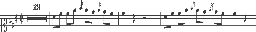


Edit distance: 0.033
Symbol error rate: 0.033
Original track:      ['clef-F4', 'keySignature-FM', 'timeSignature-C', 'multirest-4', 'barline', 'rest-eighth', 'note-C3_eighth', 'note-E3_eighth', 'note-C3_eighth', 'note-G3_quarter', 'note-G3_eighth', 'note-G3_eighth', 'barline', 'note-E3_eighth.', 'note-D3_sixteenth', 'note-C3_quarter', 'rest-eighth', 'note-G2_eighth', 'note-B2_eighth', 'note-G2_eighth', 'barline', 'note-C3_quarter', 'note-C3_eighth', 'note-E3_eighth', 'note-D3_quarter.', 'note-D3_eighth', 'barline', 'note-C3_half', 'rest-half', 'barline']
Predicted track:     ['clef-F4', 'keySignature-FM', 'timeSignature-C', 'multirest-4', 'barline', 'rest-eighth', 'note-C3_eighth', 'note-E3_eighth', 'note-C3_eighth', 'note-G3_quarter', 'note-G3_eighth', 'note-G3_eighth', 'barline', 'note-E3_eighth', 'note-D3_sixteenth', 'note-C3_quarter', 'rest-eighth', 'note-G2_eighth', 'note-B2_eighth', 'note-G2_eighth', 'barline', 'note-C3_quarter', 'note-C3_eighth', 'note-E3_eighth', 'note-D3_quar

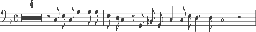


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-BbM', 'timeSignature-3/4', 'note-D5_quarter', 'note-F5_quarter', 'rest-eighth', 'note-F5_eighth', 'barline', 'note-F5_eighth', 'note-Eb5_eighth', 'note-C6_eighth', 'note-A5_eighth', 'note-F5_eighth', 'note-Eb5_eighth', 'barline', 'note-D5_quarter', 'note-F5_quarter', 'rest-eighth', 'note-F5_eighth', 'barline', 'note-F5_eighth', 'note-Eb5_eighth']
Predicted track:     ['clef-G2', 'keySignature-BbM', 'timeSignature-3/4', 'note-D5_quarter', 'note-F5_quarter', 'rest-eighth', 'note-F5_eighth', 'barline', 'note-F5_eighth', 'note-Eb5_eighth', 'note-C6_eighth', 'note-A5_eighth', 'note-F5_eighth', 'note-Eb5_eighth', 'barline', 'note-D5_quarter', 'note-F5_quarter', 'rest-eighth', 'note-F5_eighth', 'barline', 'note-F5_eighth', 'note-Eb5_eighth']
22 22


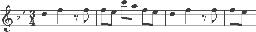


Edit distance: 0.053
Symbol error rate: 0.053
Original track:      ['clef-G2', 'keySignature-DM', 'timeSignature-4/4', 'note-F#5_quarter', 'note-A5_eighth', 'note-F#5_eighth', 'note-F#5_quarter', 'note-A5_eighth', 'note-F#5_eighth', 'barline', 'note-F#5_eighth', 'note-A4_eighth', 'note-G4_eighth', 'note-F#4_eighth', 'note-E4_eighth', 'note-D4_eighth', 'note-E4_eighth', 'note-C#4_eighth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-DM', 'timeSignature-3/4', 'note-F#5_quarter', 'note-A5_eighth', 'note-F#5_eighth', 'note-F#5_quarter', 'note-A5_eighth', 'note-F#5_eighth', 'barline', 'note-F#5_eighth', 'note-A4_eighth', 'note-G4_eighth', 'note-F#4_eighth', 'note-E4_eighth', 'note-D4_eighth', 'note-E4_eighth', 'note-C#4_eighth', 'barline']
19 19


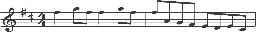


Edit distance: 0.043
Symbol error rate: 0.043
Original track:      ['clef-C1', 'keySignature-DM', 'timeSignature-4/4', 'note-D4_eighth', 'note-F#4_eighth', 'note-A4_eighth', 'note-D5_eighth', 'note-C#5_sixteenth', 'note-B4_sixteenth', 'note-A4_sixteenth', 'note-G4_sixteenth', 'note-F#4_sixteenth', 'note-E4_sixteenth', 'barline', 'note-F#4_sixteenth', 'note-D5_sixteenth', 'note-C#5_sixteenth', 'note-B4_sixteenth', 'note-A4_sixteenth', 'note-G4_sixteenth', 'note-F#4_sixteenth', 'note-E4_sixteenth', 'note-F#4_quarter']
Predicted track:     ['clef-C1', 'keySignature-DM', 'timeSignature-3/4', 'note-D4_eighth', 'note-F#4_eighth', 'note-A4_eighth', 'note-D5_eighth', 'note-C#5_sixteenth', 'note-B4_sixteenth', 'note-A4_sixteenth', 'note-G4_sixteenth', 'note-F#4_sixteenth', 'note-E4_sixteenth', 'barline', 'note-F#4_sixteenth', 'note-D5_sixteenth', 'note-C#5_sixteenth', 'note-B4_sixteenth', 'note-A4_sixteenth', 'note-G4_sixteenth', 'note-F#4_sixteenth', 'note-E4_sixteenth', 'note-F#4_quarter']
2

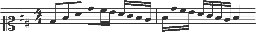


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-2/4', 'note-D4_eighth', 'barline', 'note-G4_quarter', 'note-B4_eighth.', 'note-C5_sixteenth', 'barline', 'note-D5_eighth', 'note-D4_eighth', 'rest-eighth', 'note-G4_eighth', 'barline', 'note-C5_quarter', 'note-B4_quarter', 'barline', 'note-A4_quarter', 'rest-eighth', 'note-D4_eighth', 'barline', 'note-E4_quarter', 'note-F#4_quarter', 'barline', 'note-G4_eighth', 'note-A4_eighth']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-2/4', 'note-D4_eighth', 'barline', 'note-G4_quarter', 'note-B4_eighth.', 'note-C5_sixteenth', 'barline', 'note-D5_eighth', 'note-D4_eighth', 'rest-eighth', 'note-G4_eighth', 'barline', 'note-C5_quarter', 'note-B4_quarter', 'barline', 'note-A4_quarter', 'rest-eighth', 'note-D4_eighth', 'barline', 'note-E4_quarter', 'note-F#4_quarter', 'barline', 'note-G4_eighth', 'note-A4_eighth']
26 26


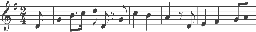


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-3/8', 'multirest-23', 'barline', 'rest-quarter', 'note-D4_eighth', 'barline', 'note-E4_sixteenth', 'note-D4_sixteenth', 'note-E4_sixteenth', 'note-F#4_sixteenth', 'note-G4_sixteenth', 'note-A4_sixteenth', 'barline', 'note-B4_eighth', 'note-A4_eighth', 'note-D5_eighth', 'barline', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-F#5_sixteenth', 'note-G5_sixteenth', 'note-A5_sixteenth', 'barline', 'note-B5_eighth', 'note-A5_eighth', 'note-E5_eighth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-3/8', 'multirest-23', 'barline', 'rest-quarter', 'note-D4_eighth', 'barline', 'note-E4_sixteenth', 'note-D4_sixteenth', 'note-E4_sixteenth', 'note-F#4_sixteenth', 'note-G4_sixteenth', 'note-A4_sixteenth', 'barline', 'note-B4_eighth', 'note-A4_eighth', 'note-D5_eighth', 'barline', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteen

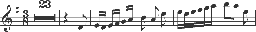


Edit distance: 0.048
Symbol error rate: 0.048
Original track:      ['clef-G2', 'keySignature-DM', 'timeSignature-3/4', 'note-D4_eighth.', 'note-A3_sixteenth', 'note-F#4_eighth.', 'note-D4_sixteenth', 'note-A4_eighth.', 'note-F#4_sixteenth', 'barline', 'note-D5_eighth.', 'note-A4_sixteenth', 'note-A4_eighth.', 'note-F#4_sixteenth', 'note-F#4_eighth.', 'note-D4_sixteenth', 'barline', 'note-A4_half', 'gracenote-A4_quarter', 'note-G4_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-DM', 'timeSignature-3/4', 'note-D4_eighth.', 'note-A3_sixteenth', 'note-F#4_eighth.', 'note-D4_sixteenth', 'note-A4_eighth.', 'note-F#4_sixteenth', 'barline', 'note-D5_eighth.', 'note-A4_sixteenth', 'note-A4_eighth.', 'note-F#4_sixteenth', 'note-F#4_eighth.', 'note-D4_sixteenth', 'barline', 'note-A4_half', 'gracenote-B4_eighth', 'note-G4_quarter', 'barline']
21 21


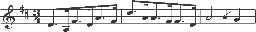


Edit distance: 0.069
Symbol error rate: 0.069
Original track:      ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'note-D5_quarter', 'rest-quarter', 'note-D5_quarter', 'gracenote-F#5_sixteenth', 'note-E5_eighth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'barline', 'note-D5_quarter', 'rest-quarter', 'note-D5_quarter', 'gracenote-F#5_sixteenth', 'note-E5_eighth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'barline', 'note-D5_quarter', 'rest-quarter', 'note-F#5_quarter', 'gracenote-A5_sixteenth', 'note-G5_eighth', 'note-F#5_sixteenth', 'note-G5_sixteenth', 'barline', 'note-F#5_quarter', 'rest-quarter']
Predicted track:     ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'note-D5_quarter', 'rest-quarter', 'note-D5_quarter', 'gracenote-F#5_eighth', 'note-E5_eighth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'barline', 'note-D5_quarter', 'rest-quarter', 'note-D5_quarter', 'gracenote-F#5_sixteenth', 'note-E5_eighth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'barline', 'note-D5_quarter'

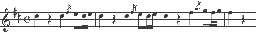


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-C1', 'keySignature-DM', 'timeSignature-C', 'note-D4_quarter', 'note-E4_quarter', 'note-F#4_quarter', 'note-A4_quarter', 'barline', 'note-G4_quarter', 'note-F#4_quarter', 'note-E4_quarter', 'note-D4_quarter_fermata', 'barline', 'note-E4_quarter', 'note-E4_quarter', 'note-F#4_eighth.', 'note-G#4_sixteenth', 'note-A4_quarter', 'tie', 'barline', 'note-A4_eighth', 'note-B4_sixteenth', 'note-C#5_sixteenth']
Predicted track:     ['clef-C1', 'keySignature-DM', 'timeSignature-C', 'note-D4_quarter', 'note-E4_quarter', 'note-F#4_quarter', 'note-A4_quarter', 'barline', 'note-G4_quarter', 'note-F#4_quarter', 'note-E4_quarter', 'note-D4_quarter_fermata', 'barline', 'note-E4_quarter', 'note-E4_quarter', 'note-F#4_eighth.', 'note-G#4_sixteenth', 'note-A4_quarter', 'tie', 'barline', 'note-A4_eighth', 'note-B4_sixteenth', 'note-C#5_sixteenth']
23 23


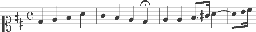


Edit distance: 0.095
Symbol error rate: 0.667
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-C/', 'note-E4_eighth', 'barline', 'note-E4_quarter.', 'note-F#4_quarter.', 'note-G4_quarter', 'note-A4_quarter', 'barline', 'note-A4_sixteenth', 'note-G4_sixteenth', 'note-A4_sixteenth', 'note-B4_sixteenth', 'note-G4_eighth', 'note-F#4_eighth', 'note-E4_eighth.', 'note-C4_sixteenth', 'note-B3_eighth.', 'note-A3_sixteenth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-C', 'note-E4_eighth', 'barline', 'note-E4_quarter.', 'note-F#4_quarter.', 'note-G4_quarter', 'note-A4_quarter', 'tie', 'barline', 'note-A4_sixteenth', 'note-G4_sixteenth', 'note-A4_sixteenth', 'note-B4_sixteenth', 'note-G4_eighth', 'note-F#4_eighth', 'note-E4_eighth.', 'note-C4_sixteenth', 'note-B3_eighth.', 'note-A3_sixteenth', 'barline']
21 22


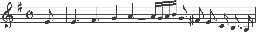


Edit distance: 0.2
Symbol error rate: 0.25
Original track:      ['clef-C3', 'keySignature-FM', 'timeSignature-C/', 'rest-whole', 'note-F3_half.', 'note-G3_quarter', 'barline', 'note-A3_quarter', 'note-F3_quarter', 'note-A3_quarter', 'note-Bb3_quarter', 'note-C4_half.', 'note-Bb3_eighth', 'note-A3_eighth', 'barline', 'note-G3_half', 'note-C4_whole', 'rest-half', 'barline', 'note-C4_half.']
Predicted track:     ['clef-C3', 'keySignature-FM', 'timeSignature-C/', 'rest-whole', 'note-F3_half.', 'note-G3_quarter', 'barline', 'note-A3_quarter', 'note-F3_quarter', 'note-A3_quarter', 'note-G3_quarter', 'note-C4_half.', 'note-G3_eighth', 'note-F3_eighth', 'barline', 'note-G3_half', 'note-C4_whole', 'rest-half', 'note-C4_half.']
20 19


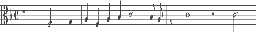


Edit distance: 0.1
Symbol error rate: 0.1
Original track:      ['clef-C1', 'timeSignature-3/8', 'note-E4_sixteenth.', 'note-D4_thirty_second', 'note-E4_eighth', 'note-F4_eighth', 'barline', 'note-G4_sixteenth.', 'note-B4_thirty_second', 'note-C5_quarter', 'barline', 'note-B4_eighth', 'gracenote-B4_thirty_second', 'gracenote-C5_thirty_second', 'note-A4_eighth', 'note-B4_eighth', 'barline', 'note-C5_eighth', 'note-G4_quarter', 'barline']
Predicted track:     ['clef-C1', 'timeSignature-3/8', 'note-E4_sixteenth.', 'note-D4_thirty_second', 'note-E4_eighth', 'note-F4_eighth', 'barline', 'note-G4_sixteenth.', 'note-B4_thirty_second', 'note-C5_quarter', 'barline', 'note-B4_eighth', 'gracenote-C5_sixteenth', 'gracenote-B4_sixteenth', 'note-A4_eighth', 'note-B4_eighth', 'barline', 'note-C5_eighth', 'note-G4_quarter', 'barline']
20 20


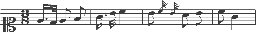


Edit distance: 0.12
Symbol error rate: 0.12
Original track:      ['clef-G2', 'keySignature-AbM', 'timeSignature-C', 'rest-half', 'note-G5_half', 'tie', 'barline', 'note-G5_quarter', 'note-F5_quarter', 'note-Bb5_half', 'tie', 'barline', 'note-Bb5_quarter', 'note-Ab5_quarter', 'note-Db6_half', 'tie', 'barline', 'note-Db6_quarter', 'note-C6_eighth', 'note-Bb5_eighth', 'note-A5_quarter', 'note-C6_quarter', 'tie', 'barline', 'note-C6_quarter']
Predicted track:     ['clef-G2', 'keySignature-AbM', 'timeSignature-C', 'rest-half', 'note-G5_half', 'tie', 'barline', 'note-G5_quarter', 'note-F5_quarter', 'note-Bb5_half', 'tie', 'barline', 'note-Bb5_quarter', 'note-Ab5_quarter', 'note-Bb5_half', 'tie', 'barline', 'note-D6_quarter', 'note-C6_eighth', 'note-Bb5_eighth', 'note-Ab5_quarter', 'note-C6_quarter', 'tie', 'barline', 'note-C6_quarter']
25 25


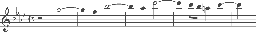


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-C', 'note-B4_quarter.', 'note-A4_eighth', 'note-G4_quarter', 'note-G4_quarter', 'barline', 'note-A4_quarter', 'note-A4_quarter', 'note-E4_quarter.', 'note-D4_eighth', 'barline', 'note-D4_eighth', 'rest-eighth', 'note-G4_quarter', 'note-G4_quarter', 'note-A4_quarter', 'barline', 'note-B4_half', 'note-D5_quarter', 'rest-quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-C', 'note-B4_quarter.', 'note-A4_eighth', 'note-G4_quarter', 'note-G4_quarter', 'barline', 'note-A4_quarter', 'note-A4_quarter', 'note-E4_quarter.', 'note-D4_eighth', 'barline', 'note-D4_eighth', 'rest-eighth', 'note-G4_quarter', 'note-G4_quarter', 'note-A4_quarter', 'barline', 'note-B4_half', 'note-D5_quarter', 'rest-quarter', 'barline']
23 23


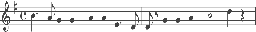


Edit distance: 0.05
Symbol error rate: 0.05
Original track:      ['clef-C1', 'keySignature-EbM', 'timeSignature-3/4', 'multirest-9', 'barline', 'note-Bb4_quarter', 'note-Eb5_quarter', 'note-C5_quarter', 'barline', 'note-Bb4_quarter', 'note-D5_quarter', 'note-Eb5_quarter', 'barline', 'note-F5_eighth.', 'note-Ab5_sixteenth', 'note-G5_quarter', 'note-F5_quarter', 'barline', 'note-Eb5_quarter', 'note-D5_quarter']
Predicted track:     ['clef-C1', 'keySignature-EbM', 'timeSignature-3/4', 'multirest-3', 'barline', 'note-Bb4_quarter', 'note-Eb5_quarter', 'note-C5_quarter', 'barline', 'note-Bb4_quarter', 'note-D5_quarter', 'note-Eb5_quarter', 'barline', 'note-F5_eighth.', 'note-Ab5_sixteenth', 'note-G5_quarter', 'note-F5_quarter', 'barline', 'note-Eb5_quarter', 'note-D5_quarter']
20 20


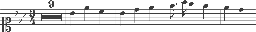


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-C1', 'keySignature-BbM', 'timeSignature-3/8', 'note-F5_eighth.', 'note-G5_sixteenth', 'note-F5_eighth', 'barline', 'note-F5_eighth', 'note-Eb5_eighth', 'note-D5_eighth', 'barline', 'note-Eb5_eighth', 'note-D5_eighth', 'rest-eighth', 'barline']
Predicted track:     ['clef-C1', 'keySignature-BbM', 'timeSignature-3/8', 'note-F5_eighth.', 'note-G5_sixteenth', 'note-F5_eighth', 'barline', 'note-F5_eighth', 'note-Eb5_eighth', 'note-D5_eighth', 'barline', 'note-Eb5_eighth', 'note-D5_eighth', 'rest-eighth', 'barline']
15 15


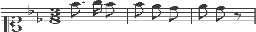


Edit distance: 0.182
Symbol error rate: 0.182
Original track:      ['clef-G2', 'timeSignature-2/4', 'note-E4_half_fermata', 'barline', 'rest-eighth', 'note-B4_eighth', 'note-G5_eighth', 'note-D#5_eighth', 'barline', 'note-E5_half', 'tie', 'barline', 'note-E5_sixteenth', 'rest-sixteenth', 'note-D#5_eighth', 'note-C6_eighth', 'note-B5_eighth', 'barline', 'note-B5_half', 'tie', 'barline', 'note-B5_sixteenth']
Predicted track:     ['clef-G2', 'timeSignature-2/4', 'note-E4_half_fermata', 'barline', 'rest-eighth', 'note-B4_eighth', 'note-G5_eighth', 'note-D#5_eighth', 'barline', 'note-E5_half', 'tie', 'barline', 'note-E5_sixteenth', 'rest-sixteenth', 'note-D#5_eighth', 'note-C6_eighth', 'note-B5_eighth', 'barline', 'note-Bb5_half', 'barline', 'tie', 'note-Bb5_sixteenth']
22 22


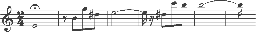


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-2/4', 'note-G4_eighth', 'note-B4_eighth', 'note-D5_eighth', 'note-G5_eighth', 'barline', 'note-B5_quarter', 'note-A5_eighth', 'note-G5_eighth', 'barline', 'note-F#5_eighth', 'note-D5_eighth', 'note-C5_eighth', 'note-B4_eighth', 'barline', 'note-C5_eighth', 'note-A4_eighth', 'note-A4_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-2/4', 'note-G4_eighth', 'note-B4_eighth', 'note-D5_eighth', 'note-G5_eighth', 'barline', 'note-B5_quarter', 'note-A5_eighth', 'note-G5_eighth', 'barline', 'note-F#5_eighth', 'note-D5_eighth', 'note-C5_eighth', 'note-B4_eighth', 'barline', 'note-C5_eighth', 'note-A4_eighth', 'note-A4_quarter', 'barline']
21 21


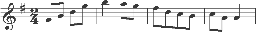


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-C/', 'note-A5_eighth.', 'note-Bb5_sixteenth', 'note-G5_eighth.', 'note-A5_sixteenth', 'barline', 'note-F5_quarter', 'rest-eighth.', 'note-A5_sixteenth', 'note-Bb5_eighth.', 'note-C6_sixteenth', 'note-A5_eighth.', 'note-Bb5_sixteenth', 'barline', 'note-G5_quarter', 'rest-eighth.', 'note-G5_sixteenth', 'note-A5_eighth', 'note-G5_eighth', 'note-Bb5_eighth', 'note-A5_eighth', 'barline', 'note-G5_eighth', 'note-G5_eighth', 'note-G5_eighth', 'rest-eighth_fermata', 'note-A4_eighth', 'rest-eighth', 'note-G4_eighth', 'rest-eighth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-C/', 'note-A5_eighth.', 'note-Bb5_sixteenth', 'note-G5_eighth.', 'note-A5_sixteenth', 'barline', 'note-F5_quarter', 'rest-eighth.', 'note-A5_sixteenth', 'note-Bb5_eighth.', 'note-C6_sixteenth', 'note-A5_eighth.', 'note-Bb5_sixteenth', 'barline', 'note-G5_quarter', 'rest-eighth.', 'n

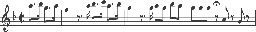


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-C1', 'keySignature-EbM', 'timeSignature-C/', 'multirest-10', 'barline', 'rest-quarter', 'rest-eighth', 'note-Eb4_eighth', 'note-Bb4_eighth', 'note-C5_sixteenth', 'note-Bb4_sixteenth', 'note-Bb4_eighth', 'note-Bb4_eighth', 'barline', 'note-Eb5_eighth', 'note-Eb4_eighth', 'note-Eb5_quarter', 'tie', 'note-Eb5_eighth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-Bb4_eighth', 'note-Ab4_eighth', 'barline', 'note-G4_sixteenth', 'note-Ab4_sixteenth', 'note-Bb4_eighth', 'note-Eb5_quarter', 'tie', 'note-Eb5_eighth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-Bb4_eighth', 'note-Ab4_eighth', 'barline', 'note-G4_sixteenth', 'note-F4_sixteenth', 'note-Eb4_eighth', 'rest-quarter']
Predicted track:     ['clef-C1', 'keySignature-EbM', 'timeSignature-C/', 'multirest-10', 'barline', 'rest-quarter', 'rest-eighth', 'note-Eb4_eighth', 'note-Bb4_eighth', 'note-C5_sixteenth', 'note-Bb4_sixteenth', 'note-Bb4_eighth', 'note-Bb4_eigh

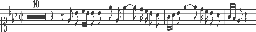

In [ ]:
for test_images, ground_truth in custom_test_ds.take(1):

  predictions = custom512.predict([test_images], CUSTOM_BATCH_SIZE)

  for image, gt, prediction in zip(test_images, ground_truth, predictions):
    decoded_prediction = decode_to_semantic(prediction.numpy())
    decoded_gt = decode_to_semantic(gt.numpy())

    print(f'Edit distance: {round(editdistance.eval(decoded_gt, decoded_prediction) / len(decoded_gt), 3)}')
    print(f'Symbol error rate: {round(ser(decoded_gt, decoded_prediction), 3)}')

    print(f'{"Original track:":20} {decoded_gt}')
    print(f'{"Predicted track:":20} {decoded_prediction}')
    print(len(decoded_gt), len(decoded_prediction))
    cv2_imshow(image.numpy() * 255)
    print("")

### Pretrained-VGG19

**Instantiate pretrained model**

In [ ]:
pretrainedVGG19 = PretrainedVGG19('pretrained-VGG19', rnn_dropout=0.35)
print('Current hyperparameters:')
for key, value in pretrainedVGG19.hyperparams.items():
  print(f' *  {key.upper():20}: {value}')

Histories loaded: 2
Scores loaded: 1
80134624/80134624 [==============================] - 0s 0us/step
Current hyperparameters:
 *  INPUT_SHAPE         : (32, 1024, 3)
 *  RNN_UNITS           : 256
 *  RNN_DROPOUT         : 0.35
 *  LEARNING_RATE       : 0.001
 *  N_SYMBOLS           : 1781
 *  MAX_SEQUENCE_LEN    : 58


In [ ]:
pretrainedVGG19.model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1024, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 1024, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 1024, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 512, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 512, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 512, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 256, 128)       0   

Hyperparameters tuning

In [ ]:
# best_hyperparameters = pretrainedVGG19.tune_hyperparams(MAX_TUNER_EPOCHS, pretrained_train_ds, pretrained_val_ds, PRETRAINED_BATCH_SIZE)
#
# print("\nBest hyperparameters: ")
# print(f'* RNN dropout: {best_hyperparameters["rnn_dropout"]}')

Training

In [ ]:
# Train for some epochs freezing pre-trained CNN
histories = pretrainedVGG19.train(
    train_ds=pretrained_train_ds,
    val_ds=pretrained_val_ds,
    epochs=EPOCHS // 2,
    batch_size=PRETRAINED_BATCH_SIZE
)

# Unfreeze pre-trained CNN
print("\nFine tuning\n")
pretrainedVGG19.conv_net.trainable = True

# Complete training on full network (fine tuning)
histories = pretrainedVGG19.train(
    train_ds=pretrained_train_ds,
    val_ds=pretrained_val_ds,
    epochs=EPOCHS,
    batch_size=PRETRAINED_BATCH_SIZE
)

Epoch 1/5
1918/1918 [==============================] - 667s 341ms/step - loss: 81.0006 - val_loss: 48.1555 - lr: 0.0010
Epoch 2/5
1918/1918 [==============================] - 668s 348ms/step - loss: 42.9129 - val_loss: 32.5077 - lr: 0.0010
Epoch 3/5
1918/1918 [==============================] - 656s 341ms/step - loss: 34.0511 - val_loss: 26.7382 - lr: 0.0010
Epoch 4/5
1918/1918 [==============================] - 664s 345ms/step - loss: 30.3162 - val_loss: 24.1864 - lr: 0.0010
Epoch 5/5
1918/1918 [==============================] - 659s 343ms/step - loss: 28.3246 - val_loss: 22.3199 - lr: 0.0010

Fine tuning

Epoch 6/10
1918/1918 [==============================] - 666s 347ms/step - loss: 25.6091 - val_loss: 20.6733 - lr: 8.5000e-04
Epoch 7/10
1918/1918 [==============================] - 667s 347ms/step - loss: 23.9885 - val_loss: 19.5457 - lr: 7.2250e-04
Epoch 8/10
1918/1918 [==============================] - 657s 341ms/step - loss: 22.4980 - val_loss: 19.1324 - lr: 6.1413e-04
Epoch 9/10


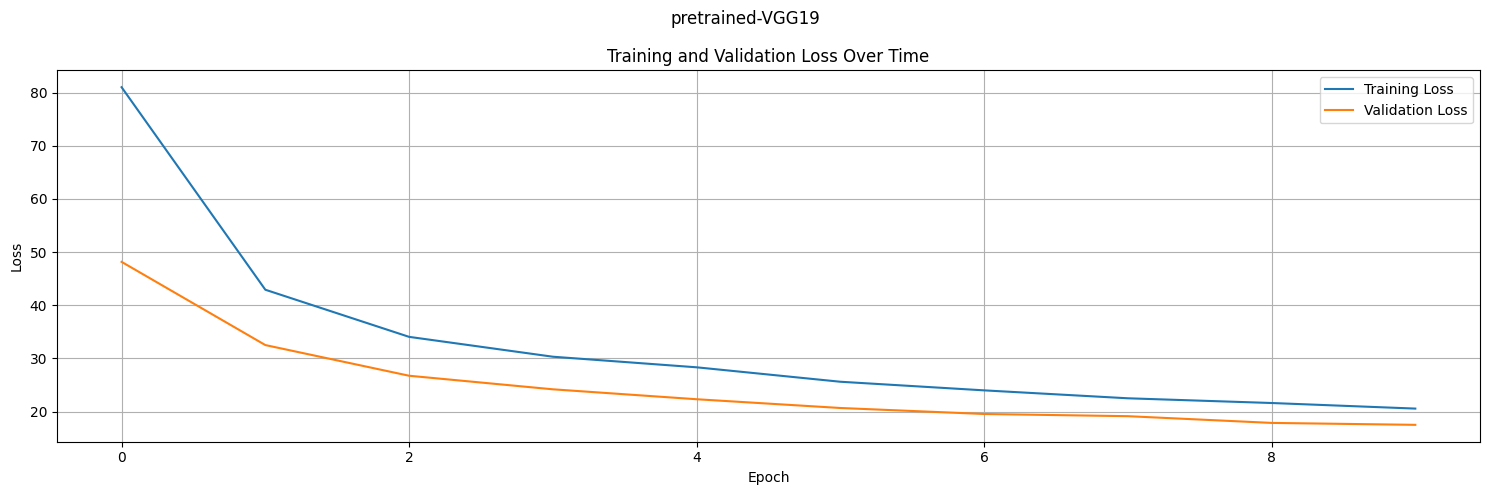

In [ ]:
pretrainedVGG19.plot_training_trend()

In [ ]:
score = pretrainedVGG19.evaluate(pretrained_test_ds)

print(f'Mean edit distance: {round(score[1], 3)}')
print(f'Symbol error rate: {round(score[2], 3)}')

548/548 [==============================] - 111s 193ms/step - loss: 0.0000e+00 - norm_edit_distance: 0.1971 - symbol_error_rate: 0.3333
Mean edit distance: 0.197
Symbol error rate: 0.333


Edit distance: 0.267
Symbol error rate: 0.3
Original track:      ['clef-F4', 'timeSignature-6/8', 'rest-quarter', 'rest-eighth', 'rest-eighth', 'note-G3_eighth', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-D3_eighth', 'note-C3_eighth', 'note-G3_quarter', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-D3_eighth', 'note-E3_eighth', 'note-C3_eighth', 'note-G3_eighth', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-D3_eighth', 'note-C3_eighth', 'note-B2_quarter', 'note-C3_eighth', 'barline', 'note-D3_quarter.', 'note-G2_quarter.', 'barline']
Predicted track:     ['clef-F4', 'timeSignature-6/8', 'rest-quarter', 'rest-eighth', 'rest-eighth', 'note-F3_eighth', 'note-F3_eighth', 'barline', 'note-D3_eighth', 'note-C3_eighth', 'note-B2_eighth', 'note-G3_quarter', 'note-E3_eighth', 'barline', 'note-D3_eighth', 'note-E3_eighth', 'note-E3_eighth', 'note-C3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-D3_eighth', 'note-C3_eighth', 'rest-eighth'

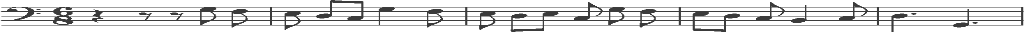


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-C1', 'keySignature-BbM', 'timeSignature-C/', 'multirest-1', 'barline', 'note-D5_quarter', 'note-D5_eighth', 'note-D5_eighth', 'note-D5_quarter', 'note-D5_quarter', 'barline', 'note-Eb5_quarter', 'note-D5_quarter', 'rest-quarter', 'note-Bb4_quarter', 'barline', 'note-C5_quarter', 'note-C5_quarter', 'gracenote-Bb4_eighth', 'note-A4_quarter.', 'note-Bb4_sixteenth', 'note-C5_sixteenth', 'barline', 'note-Bb4_quarter']
Predicted track:     ['clef-C1', 'keySignature-BbM', 'timeSignature-C/', 'multirest-1', 'barline', 'note-D5_quarter', 'note-D5_eighth', 'note-D5_eighth', 'note-D5_quarter', 'note-D5_quarter', 'barline', 'note-Eb5_quarter', 'note-D5_quarter', 'rest-quarter', 'note-Bb4_quarter', 'barline', 'note-C5_quarter', 'note-C5_quarter', 'gracenote-Bb4_eighth', 'note-A4_quarter.', 'note-Bb4_sixteenth', 'note-C5_sixteenth', 'barline', 'note-Bb4_quarter']
24 24


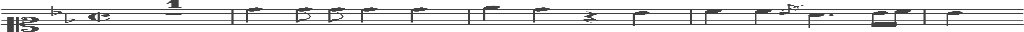


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-3/4', 'note-G4_quarter', 'note-G4_quarter', 'note-A4_eighth', 'note-G4_eighth', 'barline', 'note-F#4_quarter.', 'note-G4_eighth', 'note-A4_quarter', 'barline', 'note-B4_quarter', 'note-B4_quarter', 'note-C5_quarter', 'barline', 'note-B4_quarter.', 'note-A4_eighth', 'note-G4_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-3/4', 'note-G4_quarter', 'note-G4_quarter', 'note-A4_eighth', 'note-G4_eighth', 'barline', 'note-F#4_quarter.', 'note-G4_eighth', 'note-A4_quarter', 'barline', 'note-B4_quarter', 'note-B4_quarter', 'note-C5_quarter', 'barline', 'note-B4_quarter.', 'note-A4_eighth', 'note-G4_quarter', 'barline']
20 20


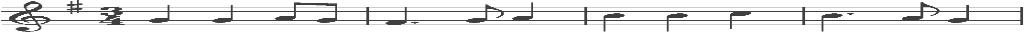


Edit distance: 0.294
Symbol error rate: 0.735
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-12/8', 'note-C5_eighth', 'barline', 'note-G5_eighth.', 'note-Ab5_sixteenth', 'note-G5_eighth', 'note-G5_quarter', 'note-G5_eighth', 'note-G5_thirty_second', 'note-Ab5_thirty_second', 'note-G5_sixteenth', 'note-F5_quarter', 'note-F5_thirty_second', 'note-G5_thirty_second', 'note-F5_sixteenth', 'note-Eb5_quarter', 'tie', 'barline', 'note-Eb5_eighth.', 'note-D5_sixteenth', 'note-F5_eighth', 'gracenote-G5_eighth', 'note-Ab5_eighth', 'gracenote-G5_eighth', 'note-F5_eighth', 'gracenote-Eb5_eighth', 'note-Db5_eighth', 'note-B4_quarter', 'note-C5_eighth', 'rest-quarter', 'rest-eighth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-6/8', 'note-C5_eighth', 'barline', 'note-G5_eighth.', 'note-Ab5_sixteenth', 'note-G5_eighth', 'note-G5_quarter', 'note-G5_eighth', 'note-G5_sixteenth', 'note-G5_thirty_second', 'note-F5_quarter', 'note-G5_thirty_second', 

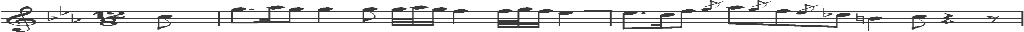


Edit distance: 0.433
Symbol error rate: 0.633
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'multirest-1', 'barline', 'note-Bb5_half.', 'note-G5_eighth.', 'note-Eb5_sixteenth', 'barline', 'note-D5_quarter', 'gracenote-C5_sixteenth', 'gracenote-D5_sixteenth', 'gracenote-Eb5_sixteenth', 'note-D5_eighth.', 'note-Eb5_sixteenth', 'note-F5_quarter', 'rest-quarter', 'barline', 'note-Bb5_half.', 'note-G5_eighth.', 'note-Eb5_sixteenth', 'barline', 'note-D5_quarter', 'gracenote-D5_sixteenth', 'gracenote-C5_sixteenth', 'gracenote-Eb5_sixteenth', 'note-D5_eighth.', 'note-Eb5_sixteenth', 'note-F5_quarter', 'rest-quarter']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'multirest-1', 'barline', 'note-Bb5_half.', 'note-G5_eighth.', 'note-Eb5_sixteenth', 'barline', 'note-Eb5_quarter', 'gracenote-Eb5_sixteenth', 'gracenote-Eb5_sixteenth', 'note-Eb5_eighth.', 'note-Eb5_sixteenth', 'note-Eb5_quarter', 'rest-quarter', 'barline', 'note-Bb5_half.', 'no

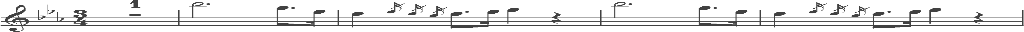


Edit distance: 0.083
Symbol error rate: 0.083
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-2/4', 'note-B4_eighth', 'note-B4_eighth', 'note-D5_eighth', 'note-D5_eighth', 'barline', 'note-G4_eighth', 'note-G4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'barline', 'note-E4_eighth', 'note-F#4_eighth', 'note-G4_eighth', 'note-A4_eighth', 'barline', 'note-B4_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-A4_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-2/4', 'note-B4_eighth', 'note-B4_eighth', 'note-D5_eighth', 'note-D5_eighth', 'barline', 'note-G4_eighth', 'note-G4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'barline', 'note-F#4_eighth', 'note-F#4_eighth', 'note-G4_eighth', 'note-A4_sixteenth', 'barline', 'note-B4_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 'note-E5_sixteenth', 'note-A4_quarter', 'barline']
24 24


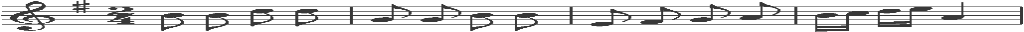


Edit distance: 0.227
Symbol error rate: 0.227
Original track:      ['clef-G2', 'keySignature-AM', 'timeSignature-C/', 'note-A4_quarter', 'barline', 'gracenote-D5_eighth', 'note-C#5_quarter', 'note-B4_eighth', 'note-A4_eighth', 'gracenote-D5_eighth', 'note-C#5_quarter', 'note-B4_eighth', 'note-A4_eighth', 'barline', 'note-E5_quarter', 'note-E4_half', 'note-E5_quarter', 'barline', 'note-A5_sixteenth', 'note-G#5_eighth.', 'note-B5_sixteenth', 'note-A5_eighth.']
Predicted track:     ['clef-G2', 'keySignature-AM', 'timeSignature-C/', 'note-A4_quarter', 'barline', 'gracenote-D5_eighth', 'note-C#5_quarter', 'note-A4_eighth', 'note-B4_eighth', 'gracenote-D5_eighth', 'note-C#5_quarter', 'note-A4_eighth', 'note-A4_eighth', 'barline', 'note-E5_quarter', 'note-E4_half', 'note-E5_quarter', 'barline', 'note-A5_sixteenth', 'note-G#5_eighth.', 'note-A5_sixteenth', 'note-B5_quarter']
22 22


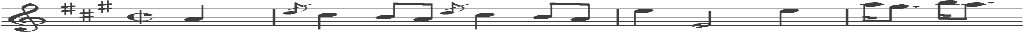


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'note-G4_quarter', 'note-F4_quarter', 'note-Eb4_quarter', 'barline', 'note-D4_half', 'note-Eb4_quarter', 'barline', 'note-F4_quarter', 'note-F4_quarter', 'note-Eb4_eighth.', 'note-G4_sixteenth', 'barline', 'note-Eb4_quarter', 'note-D4_quarter', 'rest-quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'note-G4_quarter', 'note-F4_quarter', 'note-Eb4_quarter', 'barline', 'note-D4_half', 'note-Eb4_quarter', 'barline', 'note-F4_quarter', 'note-F4_quarter', 'note-Eb4_eighth.', 'note-G4_sixteenth', 'barline', 'note-Eb4_quarter', 'note-D4_quarter', 'rest-quarter', 'barline']
19 19


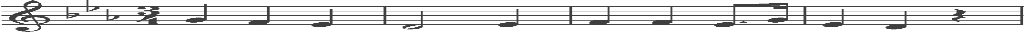


Edit distance: 0.138
Symbol error rate: 0.517
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-2/4', 'note-F4_eighth', 'barline', 'note-A4_eighth', 'note-A4_eighth', 'note-C5_eighth', 'note-C5_eighth', 'barline', 'note-C5_sixteenth', 'note-F5_sixteenth', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-C5_eighth', 'note-C5_eighth', 'barline', 'note-F4_eighth', 'note-F4_eighth', 'note-G4_eighth', 'note-G4_eighth', 'barline', 'note-A4_sixteenth', 'note-Bb4_sixteenth', 'note-A4_sixteenth', 'note-G4_sixteenth', 'note-F4_eighth', 'note-F4_eighth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-2/4', 'note-F4_eighth', 'barline', 'note-A4_eighth', 'note-A4_eighth', 'note-C5_eighth', 'barline', 'note-D5_sixteenth', 'note-F5_sixteenth', 'note-E5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-C5_eighth', 'note-C5_eighth', 'barline', 'note-F4_eighth', 'note-F4_eighth', 'note-F4_eighth', 'note-G4_eighth', 'note-G4_eighth', 'barline', 'n

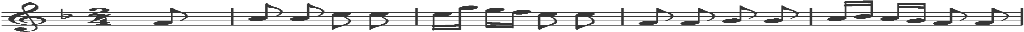


Edit distance: 0.08
Symbol error rate: 0.08
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-3/4', 'multirest-12', 'barline', 'note-A4_quarter', 'note-G4_quarter', 'note-F4_quarter', 'barline', 'note-G4_quarter.', 'note-C5_eighth', 'note-C5_eighth', 'note-E4_eighth', 'barline', 'note-F4_half', 'note-F4_quarter', 'barline', 'note-Bb4_quarter.', 'note-Bb4_eighth', 'note-Bb4_eighth', 'note-G4_eighth', 'barline', 'note-A4_half', 'rest-quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-3/4', 'multirest-12', 'barline', 'note-A4_quarter', 'note-G4_quarter', 'note-F4_quarter', 'barline', 'note-G4_quarter.', 'note-Bb4_eighth', 'note-C5_eighth', 'note-C5_eighth', 'barline', 'note-F4_half', 'note-F4_quarter', 'barline', 'note-Bb4_quarter.', 'note-Bb4_eighth', 'note-Bb4_eighth', 'note-G4_eighth', 'barline', 'note-A4_half', 'rest-quarter', 'barline']
25 25


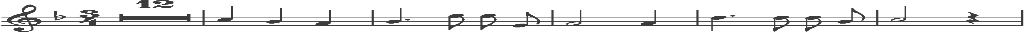


Edit distance: 0.111
Symbol error rate: 0.407
Original track:      ['clef-G2', 'keySignature-EM', 'timeSignature-C', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'barline', 'note-B4_eighth', 'note-B4_eighth', 'note-A4_eighth', 'note-A4_eighth', 'note-A4_eighth', 'note-A4_eighth', 'note-G#4_eighth', 'note-G#4_eighth', 'barline', 'note-F#4_eighth', 'note-F#4_eighth', 'note-F#4_eighth', 'note-F#4_eighth', 'note-E4_quarter', 'rest-eighth_fermata']
Predicted track:     ['clef-G2', 'keySignature-EM', 'timeSignature-C', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'note-B4_eighth', 'barline', 'note-B4_eighth', 'note-B4_eighth', 'note-A4_eighth', 'note-A4_eighth', 'note-B4_eighth', 'note-A4_eighth', 'note-G#4_eighth', 'note-G#4_eighth', 'barline', 'note-F#4_eighth', 'note-F#4_eighth', 'note-G#4_eighth', 'note-F#4_eighth', 'note-E4_qu

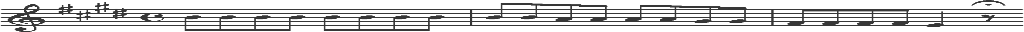


Edit distance: 0.375
Symbol error rate: 0.562
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-2/4', 'note-C5_eighth', 'barline', 'note-F5_eighth', 'note-F4_eighth', 'note-F4_eighth', 'note-F4_eighth', 'barline', 'note-F4_quarter', 'rest-eighth', 'rest-thirty_second', 'note-G4_thirty_second', 'note-A4_thirty_second', 'note-B4_thirty_second', 'barline', 'note-C5_eighth', 'note-C4_eighth', 'note-C4_eighth', 'note-C4_eighth', 'barline', 'note-C4_quarter', 'rest-eighth', 'rest-thirty_second', 'note-C4_thirty_second', 'note-D4_thirty_second', 'note-E4_thirty_second', 'barline', 'note-F4_eighth', 'note-F4_eighth', 'note-F4_eighth']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-2/4', 'note-C5_eighth', 'barline', 'note-D5_eighth', 'note-F4_eighth', 'note-F4_eighth', 'note-F4_eighth', 'barline', 'note-F4_quarter', 'rest-eighth', 'rest-sixteenth', 'note-A4_sixteenth', 'note-Bb4_thirty_second', 'barline', 'note-D5_eighth', 'note-C4_eighth', 'note-C4_eighth'

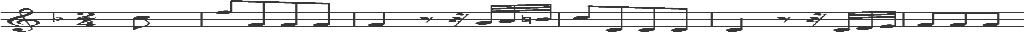


Edit distance: 0.043
Symbol error rate: 0.043
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'note-Bb3_eighth.', 'note-Bb3_sixteenth', 'barline', 'note-Eb4_quarter', 'note-F4_quarter', 'note-G4_eighth.', 'note-Ab4_sixteenth', 'barline', 'note-G4_quarter', 'note-F4_quarter', 'note-Bb4_eighth.', 'note-Bb4_sixteenth', 'barline', 'note-Eb5_quarter', 'note-F5_quarter', 'note-G5_eighth.', 'note-G5_sixteenth', 'barline', 'note-F5_quarter', 'rest-quarter']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-3/4', 'note-Bb3_eighth.', 'note-Bb3_sixteenth', 'barline', 'note-D4_quarter', 'note-F4_quarter', 'note-G4_eighth.', 'note-Ab4_sixteenth', 'barline', 'note-G4_quarter', 'note-F4_quarter', 'note-Bb4_eighth.', 'note-Bb4_sixteenth', 'barline', 'note-Eb5_quarter', 'note-F5_quarter', 'note-G5_eighth.', 'note-G5_sixteenth', 'barline', 'note-F5_quarter', 'rest-quarter']
23 23


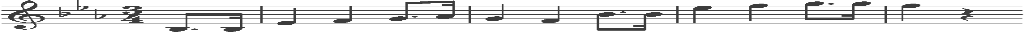


Edit distance: 0.5
Symbol error rate: 0.5
Original track:      ['clef-C1', 'keySignature-FM', 'timeSignature-12/8', 'note-F5_sixteenth', 'note-C5_sixteenth', 'note-A4_sixteenth', 'note-F4_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-F4_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 'note-Bb4_sixteenth', 'note-F4_sixteenth', 'note-E4_sixteenth', 'note-F4_sixteenth', 'note-Bb4_sixteenth', 'note-D#4_sixteenth', 'note-F4_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-Bb4_sixteenth', 'note-A4_sixteenth', 'barline']
Predicted track:     ['clef-C1', 'keySignature-BbM', 'timeSignature-3/4', 'note-F5_sixteenth', 'note-C5_sixteenth', 'note-A4_sixteenth', 'note-A4_sixteenth', 'note-A4_sixteenth', 'note-Bb4_sixteenth', 'note-A4_sixteenth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'note-F#5_sixteenth', 'note-F5_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 'note-Bb4_sixt

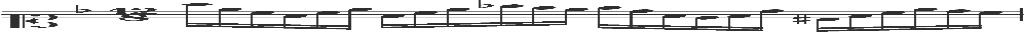


Edit distance: 0.316
Symbol error rate: 0.737
Original track:      ['clef-F4', 'keySignature-FM', 'timeSignature-C', 'rest-eighth', 'note-F3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'barline', 'note-E3_eighth', 'note-E3_sixteenth', 'note-D3_sixteenth', 'note-E3_eighth', 'note-C3_eighth', 'note-D3_eighth', 'note-D4_eighth', 'note-D4_eighth', 'note-D4_eighth', 'barline', 'note-C4_eighth', 'note-C4_sixteenth', 'note-Bb3_sixteenth', 'note-C4_eighth', 'note-A3_eighth', 'note-Bb3_eighth', 'note-Bb3_sixteenth', 'note-A3_sixteenth', 'note-Bb3_eighth', 'note-G3_eighth', 'barline', 'note-A3_eighth', 'note-F3_eighth', 'note-C4_eighth', 'note-C3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'barline']
Predicted track:     ['clef-F4', 'keySignature-FM', 'timeSignature-C', 'rest-eighth', 'note-F3_eighth', 'note-F3_eighth', 'note-F3_eighth', 'barline', 'note-E3_sixteenth', 'note-D3_sixteenth', 'note-E3_sixteenth', 'note-C3_eighth', 'note-C3_eighth', 'note-D3_si

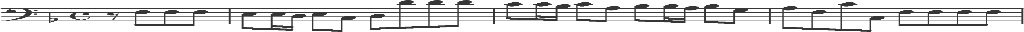


Edit distance: 0.045
Symbol error rate: 0.045
Original track:      ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'note-D4_quarter', 'rest-eighth', 'rest-sixteenth', 'note-D4_sixteenth', 'note-F#4_eighth.', 'note-D4_sixteenth', 'note-A4_eighth.', 'note-F#4_sixteenth', 'barline', 'note-D5_quarter', 'rest-eighth', 'rest-sixteenth', 'note-A4_sixteenth', 'note-D5_eighth.', 'note-A4_sixteenth', 'note-F#5_eighth.', 'note-D5_sixteenth', 'barline', 'note-A5_quarter']
Predicted track:     ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'note-D4_quarter', 'rest-eighth', 'rest-sixteenth', 'note-D4_sixteenth', 'note-F#4_eighth.', 'note-D4_sixteenth', 'note-A4_eighth.', 'note-G4_sixteenth', 'barline', 'note-D5_quarter', 'rest-eighth', 'rest-sixteenth', 'note-A4_sixteenth', 'note-D5_eighth.', 'note-A4_sixteenth', 'note-F#5_eighth.', 'note-D5_sixteenth', 'barline', 'note-A5_quarter']
22 22


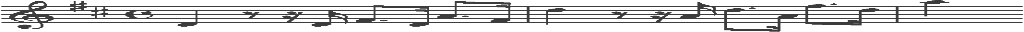


Edit distance: 0.231
Symbol error rate: 0.692
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-C', 'note-G5_quarter', 'tie', 'note-G5_eighth', 'note-F5_thirty_second', 'note-Eb5_thirty_second', 'note-D5_thirty_second', 'note-C5_thirty_second', 'barline', 'note-Ab5_eighth', 'note-G5_eighth', 'rest-sixteenth', 'note-G5_sixteenth', 'note-Eb5_sixteenth', 'note-C5_sixteenth', 'barline', 'note-C5_sixteenth', 'note-B4_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-F5_sixteenth', 'note-Eb5_sixteenth']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-C', 'note-G5_quarter', 'note-Ab5_sixteenth.', 'note-F5_thirty_second', 'note-Eb5_thirty_second', 'note-D5_thirty_second', 'note-C5_thirty_second', 'barline', 'note-Ab5_eighth', 'note-G5_eighth', 'rest-sixteenth', 'note-G5_sixteenth', 'note-Eb5_sixteenth', 'note-C5_sixteenth', 'barline', 'note-C5_sixteenth', 'note-Bb4_sixteenth', 'note-B4_sixteenth', 'note

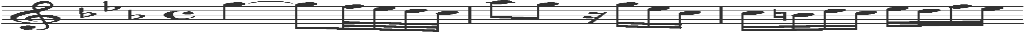


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'timeSignature-C', 'note-G4_half.', 'note-G4_quarter', 'barline', 'note-E5_quarter', 'note-E5_quarter', 'note-E5_quarter', 'note-D5_quarter', 'barline', 'note-C5_half', 'note-C5_quarter', 'note-D5_quarter', 'barline', 'note-B4_half', 'note-B4_quarter.', 'note-G4_eighth', 'barline']
Predicted track:     ['clef-G2', 'timeSignature-C', 'note-G4_half.', 'note-G4_quarter', 'barline', 'note-E5_quarter', 'note-E5_quarter', 'note-E5_quarter', 'note-D5_quarter', 'barline', 'note-C5_half', 'note-C5_quarter', 'note-D5_quarter', 'barline', 'note-B4_half', 'note-B4_quarter.', 'note-G4_eighth', 'barline']
18 18


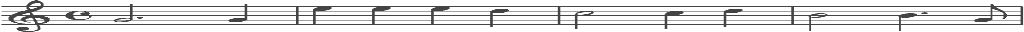


Edit distance: 0.185
Symbol error rate: 0.185
Original track:      ['clef-G2', 'keySignature-BbM', 'timeSignature-2/4', 'note-F4_eighth', 'note-Bb4_eighth', 'note-Bb4_eighth', 'note-Bb4_eighth', 'barline', 'note-C5_eighth', 'note-C5_sixteenth.', 'note-D5_thirty_second', 'note-Bb4_eighth', 'rest-eighth', 'barline', 'note-C5_eighth', 'note-C5_sixteenth.', 'note-D5_thirty_second', 'note-Bb4_eighth', 'note-Eb5_eighth', 'barline', 'note-D5_eighth', 'note-C5_eighth', 'note-F5_sixteenth', 'note-Eb5_sixteenth', 'note-C5_sixteenth', 'note-A4_sixteenth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-BbM', 'timeSignature-2/4', 'note-F4_eighth', 'note-Bb4_eighth', 'note-Bb4_eighth', 'note-Bb4_eighth', 'barline', 'note-C5_eighth', 'note-C5_sixteenth.', 'note-C5_sixteenth', 'note-Bb4_eighth', 'rest-eighth', 'barline', 'note-A4_eighth', 'note-C5_sixteenth', 'note-Bb4_sixteenth', 'note-Bb4_eighth', 'note-Eb5_eighth', 'barline', 'note-D5_eighth', 'note-C5_eighth', 'note-F5_sixteenth', 'not

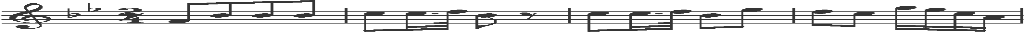


Edit distance: 0.538
Symbol error rate: 0.769
Original track:      ['clef-G2', 'keySignature-EbM', 'timeSignature-C', 'note-G5_quarter', 'note-C5_eighth.', 'note-B4_sixteenth', 'note-C5_eighth.', 'note-D5_thirty_second', 'note-Eb5_thirty_second', 'note-D5_eighth', 'note-Eb5_eighth', 'barline', 'gracenote-D5_sixteenth', 'gracenote-Eb5_sixteenth', 'note-F5_eighth.', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'note-D5_sixteenth', 'note-Eb5_sixteenth', 'gracenote-C5_eighth', 'note-B4_eighth.', 'note-C5_thirty_second', 'note-D5_thirty_second', 'note-C5_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-EbM', 'timeSignature-C', 'note-Eb5_quarter', 'note-C5_sixteenth.', 'note-C#5_thirty_second', 'note-C5_eighth.', 'note-D5_thirty_second', 'note-Eb5_eighth', 'note-Eb5_eighth', 'barline', 'gracenote-D5_sixteenth', 'gracenote-Eb5_sixteenth', 'note-Eb5_eighth.', 'note-Eb5_sixteenth', 'note-C5_sixteenth', 'note-C5_sixteenth', 'note-Eb5_sixteenth', 'note-Eb5_q

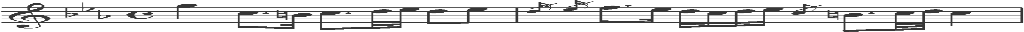


Edit distance: 0.438
Symbol error rate: 0.438
Original track:      ['clef-C2', 'keySignature-FM', 'timeSignature-4/2', 'note-F4_half', 'note-F4_quarter', 'note-F4_quarter', 'note-F4_half.', 'note-A4_quarter', 'barline', 'note-F4_quarter', 'note-Bb4_half', 'note-Bb4_quarter', 'note-Bb4_half', 'note-D4_half', 'barline', 'rest-whole']
Predicted track:     ['clef-C2', 'keySignature-FM', 'timeSignature-2/2', 'note-G4_half', 'note-F4_quarter', 'note-G4_quarter', 'note-G4_half.', 'note-A4_quarter', 'barline', 'note-G4_quarter', 'note-Bb4_half', 'note-A4_quarter', 'note-Bb4_half', 'note-D4_half', 'barline', 'note-G4_double_whole']
16 16


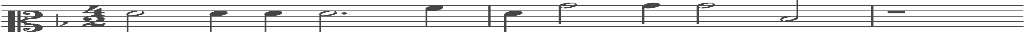


Edit distance: 0.071
Symbol error rate: 0.071
Original track:      ['clef-F4', 'timeSignature-C/', 'note-D3_half', 'note-A2_half', 'barline', 'note-D3_half', 'note-C3_half', 'barline', 'note-F3_half', 'note-C3_half', 'barline', 'note-D3_half', 'note-A2_half', 'barline']
Predicted track:     ['clef-F4', 'timeSignature-C/', 'note-D3_half', 'note-A2_half', 'barline', 'note-D3_half', 'note-C3_half', 'barline', 'note-E3_half', 'note-C3_half', 'barline', 'note-D3_half', 'note-A2_half', 'barline']
14 14


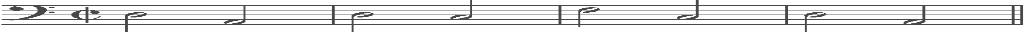


Edit distance: 0.217
Symbol error rate: 0.739
Original track:      ['clef-C4', 'timeSignature-C', 'rest-quarter', 'rest-quarter', 'rest-quarter', 'rest-eighth', 'note-A3_eighth', 'barline', 'note-C4_eighth', 'note-C4_eighth', 'rest-eighth', 'note-C4_sixteenth', 'note-D4_sixteenth', 'note-E4_quarter', 'note-D4_eighth', 'note-C4_eighth', 'barline', 'note-F4_quarter', 'rest-quarter', 'rest-half', 'barline', 'multirest-1', 'barline']
Predicted track:     ['clef-C4', 'timeSignature-C', 'rest-quarter', 'rest-quarter', 'rest-eighth', 'note-A3_eighth', 'barline', 'note-C4_eighth', 'note-C4_eighth', 'rest-eighth', 'note-C4_sixteenth', 'note-F4_quarter', 'note-C4_eighth', 'note-C4_eighth', 'barline', 'note-G4_quarter', 'rest-quarter', 'rest-half', 'barline', 'multirest-1', 'barline']
23 21


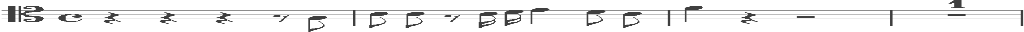


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-BbM', 'timeSignature-3/8', 'note-Bb5_quarter', 'rest-eighth', 'barline', 'note-A5_quarter', 'rest-eighth', 'barline', 'note-G5_quarter', 'rest-eighth', 'barline', 'rest-eighth', 'note-F5_sixteenth', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'barline']
Predicted track:     ['clef-G2', 'keySignature-BbM', 'timeSignature-3/8', 'note-Bb5_quarter', 'rest-eighth', 'barline', 'note-A5_quarter', 'rest-eighth', 'barline', 'note-G5_quarter', 'rest-eighth', 'barline', 'rest-eighth', 'note-F5_sixteenth', 'note-Eb5_sixteenth', 'note-D5_sixteenth', 'note-C5_sixteenth', 'barline']
18 18


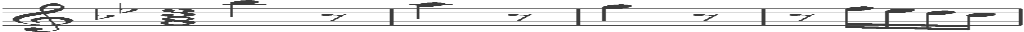


Edit distance: 0.143
Symbol error rate: 0.381
Original track:      ['clef-C1', 'keySignature-DM', 'timeSignature-C', 'multirest-33', 'barline', 'note-D4_half', 'rest-quarter', 'note-D4_quarter', 'barline', 'note-G4_half', 'note-G4_quarter', 'note-G4_quarter', 'barline', 'note-F#4_quarter.', 'note-D4_eighth', 'note-D4_quarter', 'rest-quarter', 'barline', 'multirest-5', 'barline', 'note-D4_half']
Predicted track:     ['clef-C1', 'keySignature-DM', 'timeSignature-C', 'multirest-25', 'barline', 'note-D4_half', 'rest-quarter', 'note-D4_quarter', 'barline', 'note-G4_half', 'note-G4_quarter', 'note-G4_quarter', 'barline', 'note-F#4_quarter.', 'note-D4_eighth', 'note-D4_eighth', 'note-D4_quarter', 'rest-quarter', 'barline', 'multirest-5', 'barline', 'note-A4_half']
21 22


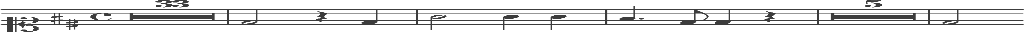


Edit distance: 0.3
Symbol error rate: 0.35
Original track:      ['clef-C4', 'keySignature-FM', 'timeSignature-C', 'multirest-3', 'barline', 'rest-half', 'rest-quarter', 'note-C4_eighth', 'note-F4_eighth', 'barline', 'note-F4_eighth', 'note-C4_eighth', 'note-A3_eighth', 'note-Bb3_eighth', 'note-C4_eighth', 'note-F4_eighth', 'note-A3_eighth', 'note-Bb3_eighth', 'barline', 'note-C4_eighth']
Predicted track:     ['clef-C4', 'keySignature-FM', 'timeSignature-C', 'multirest-5', 'barline', 'rest-half', 'rest-quarter', 'note-C4_eighth', 'note-F4_eighth', 'barline', 'note-F4_eighth', 'note-D4_eighth', 'note-C4_eighth', 'note-A3_eighth', 'note-A3_eighth', 'note-F4_eighth', 'note-C4_eighth', 'note-A3_eighth', 'barline', 'note-C4_eighth']
20 20


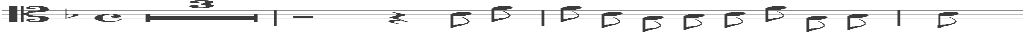


Edit distance: 0.406
Symbol error rate: 0.531
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-C', 'multirest-3', 'barline', 'rest-half', 'rest-quarter', 'note-B4_eighth.', 'note-E5_sixteenth', 'barline', 'note-E5_quarter.', 'note-E4_eighth', 'note-G4_eighth', 'note-F#4_eighth', 'note-E4_eighth', 'note-D#4_eighth', 'barline', 'note-E4_eighth.', 'note-D#4_sixteenth', 'note-E4_eighth', 'note-F#4_eighth', 'note-B3_quarter', 'note-B4_eighth.', 'note-A4_sixteenth', 'barline', 'note-A4_eighth', 'note-G4_eighth', 'note-F#4_eighth', 'note-E4_eighth', 'note-D#4_quarter', 'note-E4_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-C', 'multirest-3', 'barline', 'rest-half', 'rest-quarter', 'note-B4_eighth.', 'note-D5_sixteenth', 'barline', 'note-D5_quarter.', 'note-D4_eighth', 'note-E4_eighth', 'note-F#4_eighth', 'note-B4_eighth', 'note-D#4_eighth', 'barline', 'note-D#4_eighth', 'note-D#4_eighth', 'rest-eighth', 'note-D4_quarter', 'note-B4_q

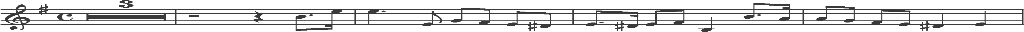


Edit distance: 0.207
Symbol error rate: 0.207
Original track:      ['clef-G2', 'keySignature-GM', 'timeSignature-C/', 'note-B4_quarter', 'note-C5_eighth', 'note-D5_eighth', 'barline', 'note-G4_half', 'note-D5_quarter', 'note-E5_eighth', 'note-F#5_eighth', 'barline', 'note-G5_eighth', 'note-F#5_eighth', 'note-G5_eighth', 'note-D5_eighth', 'note-E5_eighth', 'note-D5_eighth', 'note-E5_eighth', 'note-C5_eighth', 'barline', 'note-D5_quarter', 'note-B4_quarter', 'note-D5_eighth', 'note-C5_eighth', 'note-B4_eighth', 'note-A4_eighth', 'barline', 'note-G4_half']
Predicted track:     ['clef-G2', 'keySignature-GM', 'timeSignature-C/', 'note-B4_quarter', 'note-C5_eighth', 'note-C5_eighth', 'barline', 'note-G4_half', 'note-D5_quarter', 'note-D5_eighth', 'note-F#5_eighth', 'barline', 'note-F#5_eighth', 'note-F#5_eighth', 'note-G5_eighth', 'note-E5_eighth', 'note-E5_eighth', 'note-E5_eighth', 'note-E5_eighth', 'note-C5_eighth', 'barline', 'note-D5_quarter', 'note-B4_quarter', 'note-C5_eighth', 'note

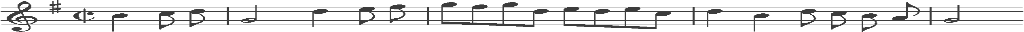


Edit distance: 0.125
Symbol error rate: 0.375
Original track:      ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'note-D4_quarter', 'note-A4_quarter', 'note-G4_quarter', 'note-F#4_quarter', 'barline', 'note-G4_whole', 'barline', 'rest-quarter', 'note-G4_eighth', 'note-F#4_sixteenth', 'note-G4_sixteenth', 'note-A4_eighth', 'note-G4_eighth', 'note-F#4_eighth', 'note-G4_eighth', 'barline', 'note-A4_quarter', 'note-F#4_quarter', 'note-F#4_quarter', 'note-F#4_quarter', 'barline']
Predicted track:     ['clef-G2', 'keySignature-DM', 'timeSignature-C', 'note-D4_quarter', 'note-A4_quarter', 'note-G4_quarter', 'note-F#4_quarter', 'barline', 'note-G4_whole', 'barline', 'rest-quarter', 'note-G4_sixteenth', 'note-F#4_sixteenth', 'note-A4_eighth', 'note-A4_eighth', 'note-F#4_eighth', 'note-G4_eighth', 'barline', 'note-A4_quarter', 'note-F#4_quarter', 'note-F#4_quarter', 'note-F#4_quarter', 'barline']
24 23


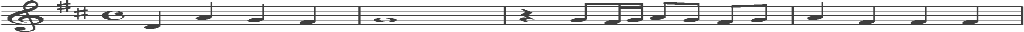


Edit distance: 0.0
Symbol error rate: 0.0
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-3/1', 'rest-whole', 'rest-whole', 'note-Bb4_whole', 'note-Bb4_double_whole', 'note-D5_whole', 'note-C5_double_whole', 'note-Bb4_whole', 'note-C5_whole.', 'note-D5_half', 'note-E5_whole', 'note-F5_double_whole', 'note-F5_whole']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-3/1', 'rest-whole', 'rest-whole', 'note-Bb4_whole', 'note-Bb4_double_whole', 'note-D5_whole', 'note-C5_double_whole', 'note-Bb4_whole', 'note-C5_whole.', 'note-D5_half', 'note-E5_whole', 'note-F5_double_whole', 'note-F5_whole']
15 15


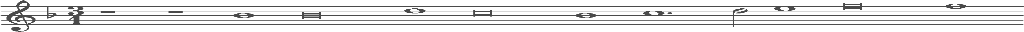


Edit distance: 0.105
Symbol error rate: 0.105
Original track:      ['clef-G2', 'keySignature-FM', 'timeSignature-C', 'note-D5_quarter', 'note-A4_quarter', 'note-Bb4_eighth', 'note-A4_eighth', 'note-A4_quarter', 'barline', 'note-G4_quarter.', 'note-A4_eighth', 'note-F4_eighth', 'note-D4_eighth', 'note-F5_eighth', 'note-Eb5_eighth', 'barline', 'note-D5_eighth', 'note-E5_eighth', 'note-F5_quarter']
Predicted track:     ['clef-G2', 'keySignature-FM', 'timeSignature-C', 'note-D5_quarter', 'note-A4_quarter', 'note-Bb4_eighth', 'note-A4_eighth', 'note-A4_quarter', 'barline', 'note-A4_quarter.', 'note-A4_eighth', 'note-F4_eighth', 'note-E4_eighth', 'note-F5_eighth', 'note-Eb5_eighth', 'barline', 'note-D5_eighth', 'note-E5_eighth', 'note-F5_quarter']
19 19


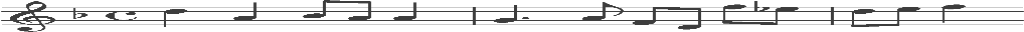


Edit distance: 0.4
Symbol error rate: 0.4
Original track:      ['clef-G1', 'timeSignature-C', 'note-C5_quarter.', 'note-G5_eighth', 'note-E5_quarter', 'note-D5_eighth', 'note-C5_eighth', 'barline', 'note-F5_quarter.', 'note-F5_eighth', 'note-F5_quarter.', 'note-G5_eighth', 'barline', 'note-E5_quarter.', 'note-E5_eighth', 'note-D5_quarter', 'note-C5_eighth', 'note-B4_eighth', 'barline', 'note-C5_quarter.', 'note-C5_eighth', 'note-C5_quarter.', 'note-B4_eighth', 'barline', 'note-A4_half']
Predicted track:     ['clef-G1', 'timeSignature-C', 'note-C5_quarter.', 'note-E5_eighth', 'note-D5_quarter', 'note-C5_eighth', 'note-C5_eighth', 'barline', 'note-E5_quarter.', 'note-F5_eighth', 'note-F5_quarter.', 'note-F5_eighth', 'barline', 'note-D5_quarter.', 'note-D5_eighth', 'note-D5_quarter', 'note-D5_eighth', 'note-C5_eighth', 'barline', 'note-C5_quarter.', 'note-C5_eighth', 'note-C5_quarter.', 'note-A4_eighth', 'barline', 'note-A4_half']
25 25


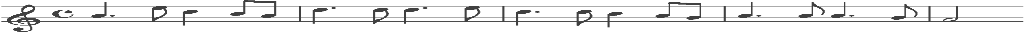

In [ ]:
for test_images, ground_truth in pretrained_test_ds.take(1):

  predictions = pretrainedVGG19.predict([test_images], batch_size=PRETRAINED_BATCH_SIZE)

  for image, gt, prediction in zip(test_images, ground_truth, predictions):
    decoded_prediction = decode_to_semantic(prediction.numpy())
    decoded_gt = decode_to_semantic(gt.numpy())

    print(f'Edit distance: {round(editdistance.eval(decoded_gt, decoded_prediction) / len(decoded_gt), 3)}')
    print(f'Symbol error rate: {round(ser(decoded_gt, decoded_prediction), 3)}')

    print(f'{"Original track:":20} {decoded_gt}')
    print(f'{"Predicted track:":20} {decoded_prediction}')
    print(len(decoded_gt), len(decoded_prediction))
    cv2_imshow(image.numpy() * 255)
    print("")


### Errors Analysis

In [ ]:
def error_rate_per_symbols(model, test_set, batch_size):

  symb_err = {symbol: {'errs': 0, 'tot':0} for symbol in available_symbols}

  # Load from drive if available
  if os.path.exists(os.path.join(model.dirs['model'], 'symbol_errs.json')):
    with open(os.path.join(model.dirs['model'], 'symbol_errs.json'), 'r') as fp:
      symb_err = json.load(fp)
  else:
    # Compute the error rate per each symbol
    for test_images, ground_truth in test_set:

      # Compute predictions
      predictions = model.predict([test_images], batch_size)

      # Count errors per (decoded) symbol
      for gt, prediction in zip(ground_truth, predictions):
        decoded_prediction = decode_to_semantic(prediction.numpy())
        decoded_gt = decode_to_semantic(gt.numpy())

        # Pad-right predicted sequence if necessary
        while len(decoded_gt) > len(decoded_prediction):
          decoded_prediction.append(-1)

        # Count errors
        for gt, pred in zip(decoded_gt, decoded_prediction):
          symb_err[gt]['tot'] += 1
          if gt != pred:
            symb_err[gt]['errs'] += 1

    # Store to drive folder
    with open(os.path.join(model.dirs['model'], 'symbol_errs.json'), 'w') as fp:
      json.dump(symb_err, fp)

  rates = []
  for key in symb_err:
    if symb_err[key]['tot'] > 0:
      rates.append((symb_err[key]['tot'], symb_err[key]['errs'] / symb_err[key]['tot']))
    else:
      rates.append((0, 0))

  return rates

In [ ]:
def plot_rates(rates, model_name):
  fig, axes = plt.subplots(2, 2, figsize=(25, 10))
  axes = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
  for index, limit in enumerate([(0, 10**1), (0, 10**2) , (0, 10**3), (0, 10**4)]):
    x = []
    y = []

    for occ, rate in rates:
      if occ > limit[0] and occ < limit[1]:
        x.append(occ)
        y.append(rate)

    axes[index].scatter(x, y, marker='.')

    axes[index].grid(linestyle='dotted')
    axes[index].set_xlim(0, max(x))
    axes[index].set_xlabel('Ground Truth Occurrences', fontsize=12)
    axes[index].set_ylabel('Error rate per Symbol', fontsize=12)
    axes[index].set_title(f'Range [0, {limit[1]}]')
    axes[index].set_xticks(np.linspace(0, limit[1], 6), labels=[int(l) for l in np.linspace(0, limit[1], 6)], fontsize=14)
    axes[index].set_yticks(np.linspace(0, 1, 6), labels=np.round(np.linspace(0, 1, 6),1), fontsize=14)
    axes[index].set_axisbelow(True)

  # fig.suptitle(f'{model_name}}', fontsize=14)
  fig.tight_layout()
  fig.savefig(f'{model_name}.pdf')
  fig.show()

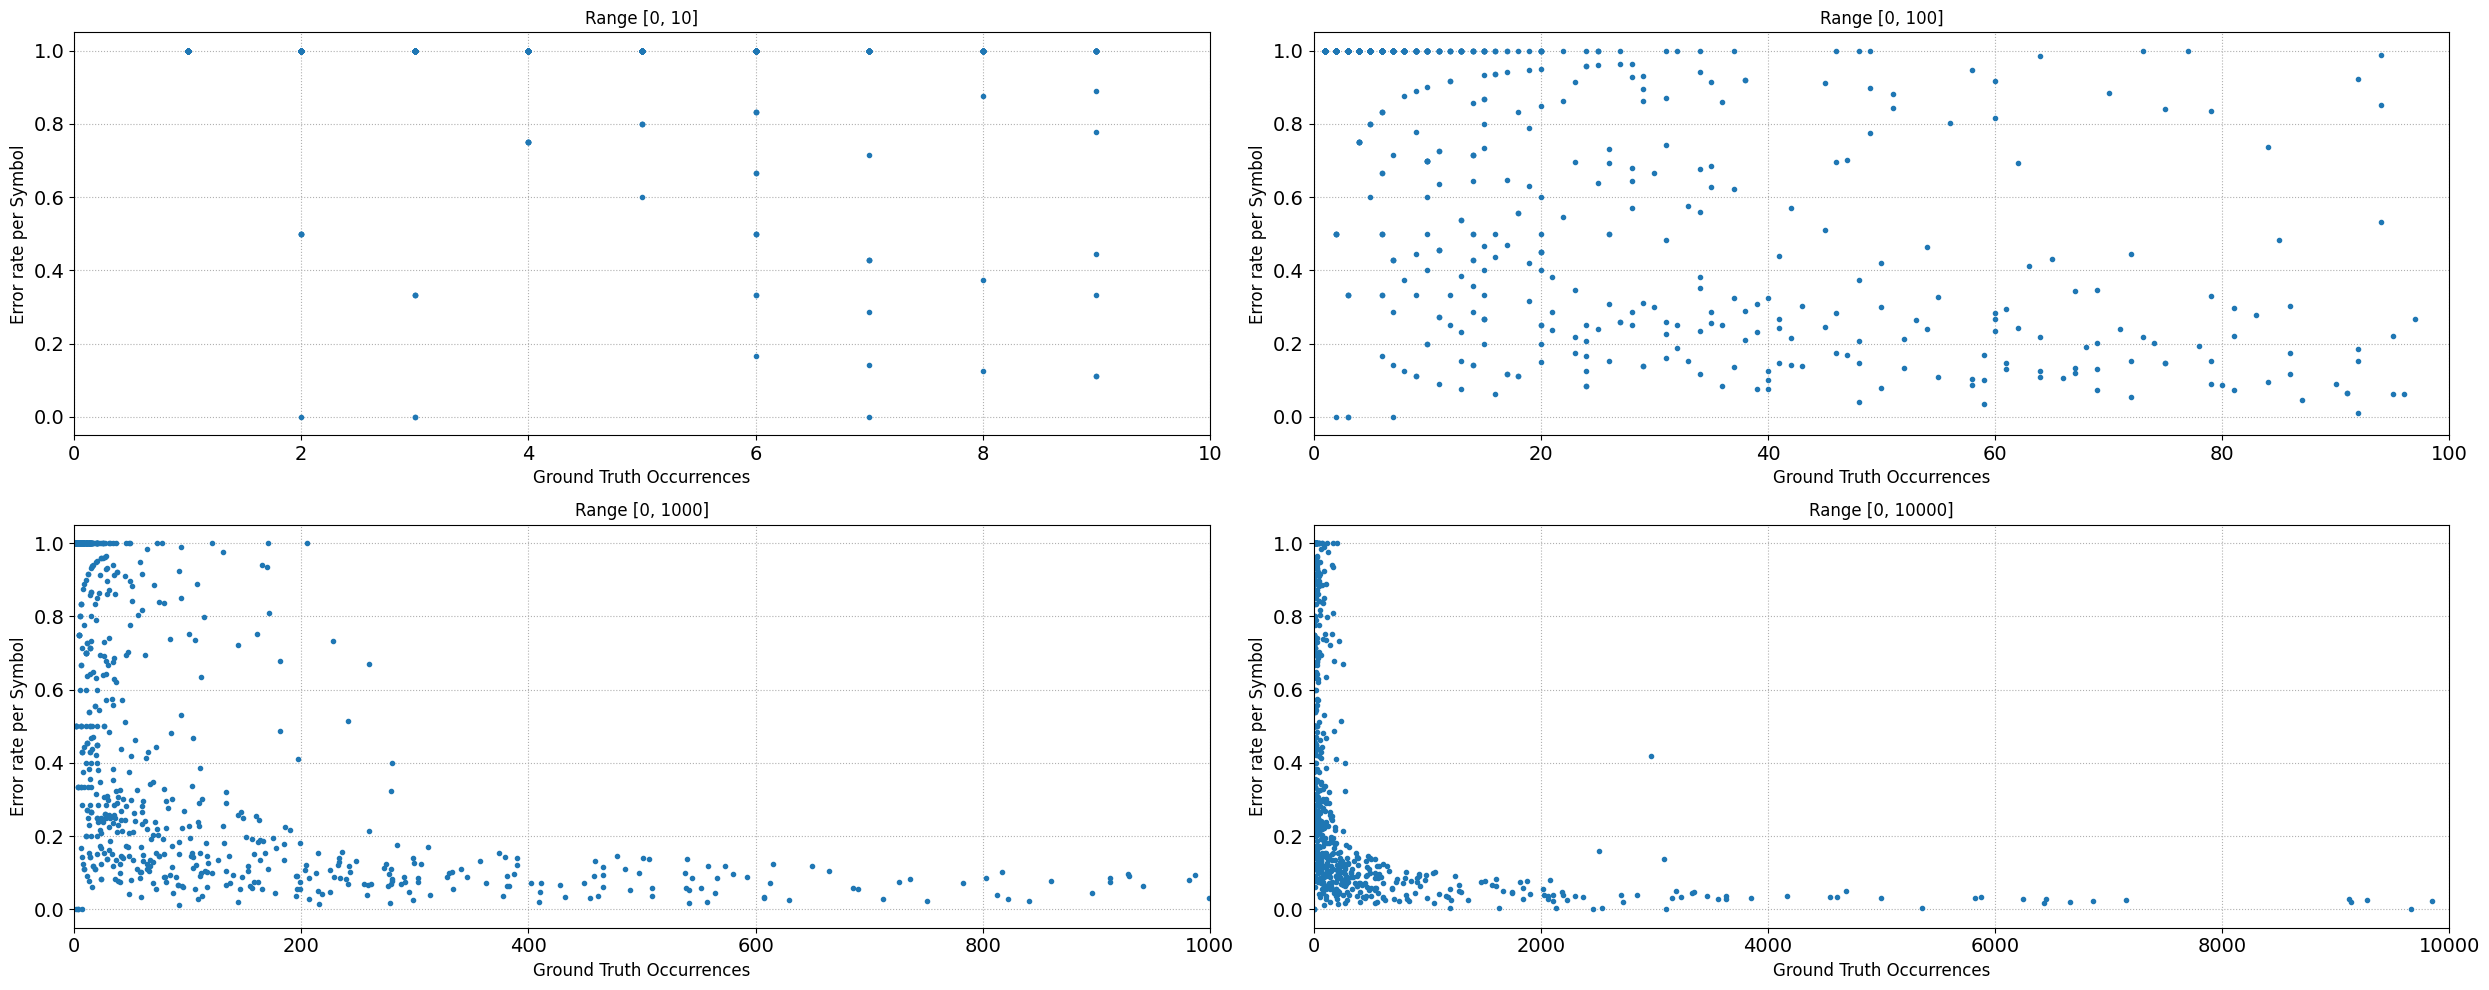

In [ ]:
plot_rates(error_rate_per_symbols(custom512, custom_test_ds, CUSTOM_BATCH_SIZE), 'custom512')